In [1]:
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.optimize import minimize, LinearConstraint, Bounds

# Configs

In [2]:
TOTAL_ITEMS_TARGET = 20000
#K_PRIOR = 40
LAMBDA_MIX = 0.3
SCORE_BINS = list(range(6))

# Load data

In [4]:
INPUT_ROOT = "../Annotated_Benchmarks"
pattern = os.path.join(INPUT_ROOT, "**", "*_annotations.csv")
paths = sorted(glob.glob(pattern, recursive=True))
if not paths:
    raise FileNotFoundError(f"No CSV files found under {os.path.abspath(INPUT_ROOT)!r}")

In [5]:
len(paths)

27

In [999]:
# Python
EXPECTED_DIMS = [
    'Causal Reasoning',
    'Cognitive Flexibility',
    'Emotion Perception and Empathy',
    'Episodic Memory',
    'Functional Perception',
    'Inhibitory Control',
    'Language',
    'Mental Simulation',
    'Metacognition',
    'Object Permanence',
    'Perception and Pattern Recognition',
    'Planning',
    'Procedural Memory',
    'Prospective Memory',
    'Semantic Memory',
    'Spatial Reasoning and Navigation',
    'Theory of Mind',
    'Working Memory',
]

def check_dataset_dimensions(df, dataset_name, dim_col="dimension"):
    have = set(df[dim_col].unique())
    want = set(EXPECTED_DIMS)

    missing = sorted(want - have)
    unexpected = sorted(have - want)

    if missing:
        print(f"\n{dataset_name} has missing dimensions:", missing)
    if unexpected:
        print(f"{dataset_name} has unexpected dimensions:", unexpected)
    return missing, unexpected

In [1002]:
REQUIRED_COLS = ["dataset name", "sample id", "dimension", "score"]

def load_and_clean_csv(p: str):
    """Read one CSV, enforce schema, clean scores, and report issues.
    Returns (df_clean, dimension_issues: bool). Raises on hard errors."""
    try:
        df = pd.read_csv(p)
    except Exception as e:
        raise RuntimeError(f"Failed to read CSV: {p}") from e

    # Strict schema
    if not set(REQUIRED_COLS).issubset(df.columns):
        missing = sorted(set(REQUIRED_COLS) - set(df.columns))
        raise ValueError(f"File {p} is missing required columns: {missing}")

    # Keep just required in fixed order
    df = df[REQUIRED_COLS].copy()

    # Remove unwanted dimensions
    df = df[~df["dimension"].isin(["ambiguity", "factuality"])]

    # Coerce score and drop non-numerics (with detailed log)
    df["score"] = pd.to_numeric(df["score"], errors="coerce")
    mask_bad = df["score"].isna()
    if mask_bad.any():
        bad_rows = df.loc[mask_bad, REQUIRED_COLS]
        print(f"\n[WARN] {p}: removing {len(bad_rows)} rows with non-numeric 'score':")
        for _, r in bad_rows.iterrows():
            print(f"  - dataset={r['dataset name']}, sample_id={r['sample id']}, "
                  f"dimension={r['dimension']}, score={r['score']!r}")
        df = df.loc[~mask_bad].copy()

    # Warn about out-of-range scores; keep them (matches your current behaviour)
    bad_range = ~((df["score"] >= 0) & (df["score"] <= 5))
    if bad_range.any():
        print(f"[WARN] {p}: 'score' outside 0..5 in {int(bad_range.sum())} rows.")

    # Required fields not empty
    if df[["dataset name", "sample id", "dimension"]].isna().any().any():
        raise ValueError(f"File {p} has missing values in required columns.")

    # Duplicate check (exact row duplicates)
    if df.duplicated().any():
        print(f"\n[WARN] {p}: contains exact duplicate rows.")

    # Dimension sanity check (your existing helper)
    ds_names = df["dataset name"].unique()
    missing, unexpected = check_dataset_dimensions(df, ds_names, dim_col="dimension")
    dimension_issues = bool(missing or unexpected)

    return df, dimension_issues


# -------- Main loop --------
all_dfs, dfs = [], []
for p in paths:
    df, has_dim_issues = load_and_clean_csv(p)
    all_dfs.append(df)
    if not has_dim_issues:
        dfs.append(df)

if not dfs:
    raise RuntimeError("No CSV matched the expected schema (dataset name, sample id, dimension, score).")


[WARN] ../Evaluations/BigToM/bigtom_annotations.csv: removing 1 rows with non-numeric 'score':
  - dataset=BigToM_annotation, sample_id=1134, dimension=Planning, score=nan

['deepmind/narrativeqa_annotation'] has missing dimensions: ['Emotion Perception and Empathy', 'Episodic Memory', 'Functional Perception', 'Metacognition', 'Object Permanence', 'Perception and Pattern Recognition', 'Planning', 'Procedural Memory', 'Prospective Memory', 'Semantic Memory', 'Spatial Reasoning and Navigation', 'Theory of Mind', 'Working Memory']
['deepmind/narrativeqa_annotation'] has unexpected dimensions: ['Emotion Perception & Empathy (EPE)', 'Episodic/Episodic-Like Memory', 'Executive Function (EF)', 'Functional perception']

[WARN] ../Evaluations/Plan_Bench/plan_bench_annotations.csv: removing 1 rows with non-numeric 'score':
  - dataset=plan_bench_annotation, sample_id=blocksworld_task_6_replanning_372, dimension=Working Memory, score=nan


In [1004]:
dfs[1].head()

,dataset name,sample id,dimension,score
0,AGIEval_annotation,1007,Causal Reasoning,2
1,AGIEval_annotation,1007,Cognitive Flexibility,2
2,AGIEval_annotation,1007,Emotion Perception and Empathy,0
3,AGIEval_annotation,1007,Episodic Memory,0
4,AGIEval_annotation,1007,Functional Perception,2


In [930]:
dfs[0]['dataset name'] = 'AGIEval_freeform_annotations'
dfs[1]['dataset name'] = 'AGIEval_mcq_annotations'

In [931]:
list(dfs[0]['dimension'].unique())

['Causal Reasoning',
 'Cognitive Flexibility',
 'Emotion Perception and Empathy',
 'Episodic Memory',
 'Functional Perception',
 'Inhibitory Control',
 'Language',
 'Mental Simulation',
 'Metacognition',
 'Object Permanence',
 'Perception and Pattern Recognition',
 'Planning',
 'Procedural Memory',
 'Prospective Memory',
 'Semantic Memory',
 'Spatial Reasoning and Navigation',
 'Theory of Mind',
 'Working Memory']

In [932]:
print(f"number of datasets: {len(dfs)}\n")
for i, df in enumerate(dfs):
    ds_names = df["dataset name"].unique()
    n_dims = df["dimension"].nunique()
    n_items = df["sample id"].nunique()
    print(f"[{i+1}] {ds_names[0]}: \n\tnumber of dimensions = {n_dims}; number of items = {n_items}\n")

number of datasets: 23

[1] AGIEval_freeform_annotations: 
	number of dimensions = 18; number of items = 200

[2] AGIEval_mcq_annotations: 
	number of dimensions = 18; number of items = 200

[3] abstract_narrative_understanding_annotation: 
	number of dimensions = 18; number of items = 200

[4] BigBenchHard_annotation: 
	number of dimensions = 18; number of items = 200

[5] BigToM_annotation: 
	number of dimensions = 18; number of items = 200

[6] cause_and_effect_annotation: 
	number of dimensions = 18; number of items = 51

[7] CoQA_annotation: 
	number of dimensions = 18; number of items = 200

[8] Crow_annotation: 
	number of dimensions = 18; number of items = 200

[9] ewok-core/ewok-core-1.0_annotation: 
	number of dimensions = 18; number of items = 200

[10] EmoBench_annotation: 
	number of dimensions = 18; number of items = 200

[11] evaluating_information_essentiality_annotation: 
	number of dimensions = 18; number of items = 68

[12] fantasy_reasoning_annotation: 
	number of d

# Current count and remaining budget

In [933]:
data = pd.concat(dfs, ignore_index=True)
items_per_dataset = data.drop_duplicates(subset=["dataset name","sample id"]).groupby("dataset name").size()
current_total_items = int(items_per_dataset.sum())
remaining_items = max(TOTAL_ITEMS_TARGET - current_total_items, 0)

In [934]:
items_per_dataset

dataset name
AGIEval_freeform_annotations                      200
AGIEval_mcq_annotations                           200
BigBenchHard_annotation                           200
BigToM_annotation                                 200
CoQA_annotation                                   200
Crow_annotation                                   200
EmoBench_annotation                               200
Fantom_annotation                                 200
MacGyver_annotation                               200
OpenToM_annotation                                200
TIGER-Lab/MMLU-Pro_annotation                     200
ZhengyanShi/StepGame_annotation                   200
abstract_narrative_understanding_annotation       200
cause_and_effect_annotation                        51
evaluating_information_essentiality_annotation     68
ewok-core/ewok-core-1.0_annotation                200
fantasy_reasoning_annotation                      200
intuit_annotation                                 200
known_unknowns_

In [935]:
data.describe(include="all")

,dataset name,sample id,dimension,score
count,74968,74968.000000,74968,74968.000000
unique,23,3334.000000,18,NaN
top,AGIEval_freeform_annotations,34.000000,Causal Reasoning,NaN
freq,3600,144.000000,4165,NaN
mean,NaN,NaN,NaN,0.928063
std,NaN,NaN,NaN,1.041197
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,2.000000


In [936]:
data['dataset name'].value_counts()

dataset name
AGIEval_freeform_annotations                      3600
AGIEval_mcq_annotations                           3600
text_navigation_annotation                        3600
ZhengyanShi/StepGame_annotation                   3600
socialnormdataset/social_annotation               3600
OpenToM_annotation                                3600
maximegmd/MetaMedQA_annotation                    3600
MacGyver_annotation                               3600
intuit_annotation                                 3600
Fantom_annotation                                 3600
fantasy_reasoning_annotation                      3600
EmoBench_annotation                               3600
ewok-core/ewok-core-1.0_annotation                3600
Crow_annotation                                   3600
CoQA_annotation                                   3600
BigBenchHard_annotation                           3600
abstract_narrative_understanding_annotation       3600
TIGER-Lab/MMLU-Pro_annotation                     36

In [937]:
data['dimension'].value_counts()

dimension
Causal Reasoning                      4165
Cognitive Flexibility                 4165
Theory of Mind                        4165
Spatial Reasoning and Navigation      4165
Semantic Memory                       4165
Prospective Memory                    4165
Procedural Memory                     4165
Perception and Pattern Recognition    4165
Object Permanence                     4165
Metacognition                         4165
Mental Simulation                     4165
Language                              4165
Inhibitory Control                    4165
Functional Perception                 4165
Episodic Memory                       4165
Emotion Perception and Empathy        4165
Planning                              4164
Working Memory                        4164
Name: count, dtype: int64

# Capabilities list

In [938]:
capabilities = sorted(data["dimension"].unique().tolist())
C = len(capabilities)

# Global difficulty proportions per capability

For each capability $c$ and difficulty $d$:
$$
p_{\text{global},c,d}
= \frac{A_{c,d} + \epsilon}{\;m_c + \epsilon \cdot |D|\;}
$$

where:
- $A_{c,d}$ is the raw global count (summed across datasets) for capability c, difficulty d.
-  $m_c = \sum_{d} A_{c,d}$ is the total assignments for capability c.
- $\epsilon = 0.5$ is the Laplace smoothing constant.
- $|D|$ is the number of difficulty bins (here 6).

In [939]:
global_counts = (data.groupby(["dimension","score"]).size()
                   .unstack(fill_value=0)
                   .reindex(columns=SCORE_BINS, fill_value=0))

eps = 0.5 #add for laplace smoothing
m_per_cap_global = global_counts.sum(axis=1)
p_global = (global_counts + eps).div((m_per_cap_global + eps*len(SCORE_BINS)), axis=0)

In [940]:
p_global.head()

score,0,1,2,3,4,5
dimension,,,,,,
Causal Reasoning,0.375600,0.507558,0.098968,0.017394,0.000360,0.000120
Cognitive Flexibility,0.576895,0.136156,0.175744,0.090331,0.020513,0.000360
Emotion Perception and Empathy,0.836732,0.082893,0.072817,0.007078,0.000360,0.000120
Episodic Memory,0.687020,0.208133,0.066819,0.036348,0.001320,0.000360
Functional Perception,0.211492,0.429822,0.201655,0.133277,0.023153,0.000600


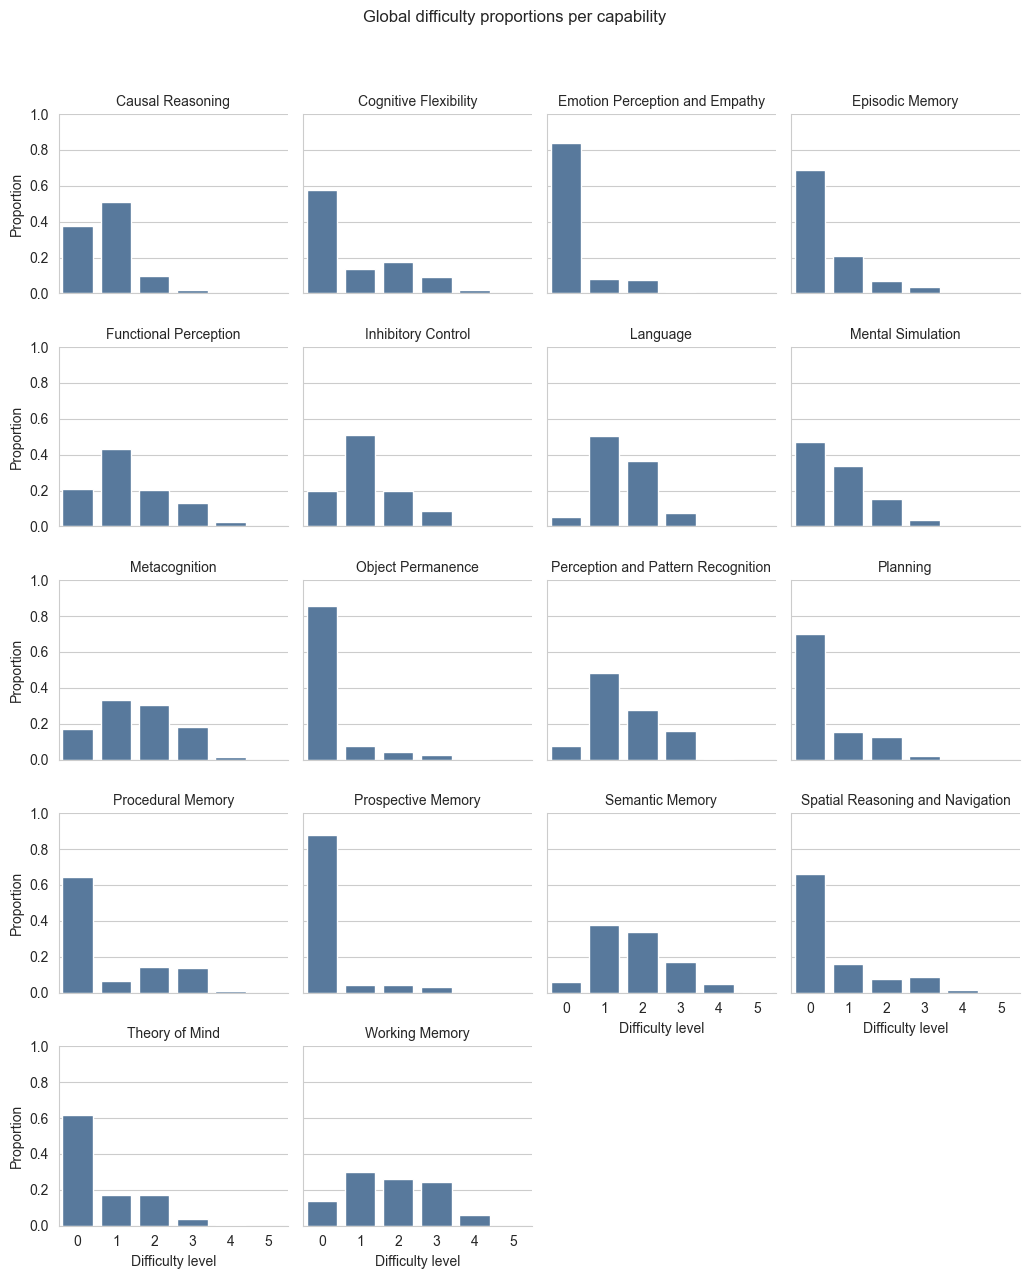

In [941]:
df_long = p_global.reset_index().melt(id_vars="dimension", var_name="score", value_name="proportion")

g = sns.FacetGrid(df_long, col="dimension", col_wrap=4, sharex=True, sharey=True, height=2.6)
g.map_dataframe(sns.barplot, x="score", y="proportion", color="#4C78A8")
g.set_titles("{col_name}")
g.set_xlabels("Difficulty level")
g.set_ylabels("Proportion")
for ax in g.axes.flat:
    ax.set_ylim(0, 1)
plt.subplots_adjust(top=0.9)
g.figure.suptitle("Global difficulty proportions per capability")
plt.show()

# Achieved assignment counts $A_{c,d}$

In [942]:
A_cd = global_counts.reindex(index=capabilities, columns=SCORE_BINS, fill_value=0)
A_cd

score,0,1,2,3,4,5
dimension,,,,,,
Causal Reasoning,1565,2115,412,72,1,0
Cognitive Flexibility,2404,567,732,376,85,1
Emotion Perception and Empathy,3487,345,303,29,1,0
Episodic Memory,2863,867,278,151,5,1
Functional Perception,881,1791,840,555,96,2
Inhibitory Control,828,2131,835,361,10,0
Language,229,2109,1523,303,1,0
Mental Simulation,1956,1412,638,155,4,0
Metacognition,702,1378,1260,767,57,1


# Assignment-level targets $T_{c,d}$

Mix uniform and global proportions:

$$
\mathrm{mix}_{c} = \lambda\, \mathbf{u}_D + (1-\lambda)\, \mathbf{p}_{\mathrm{global},c},
\quad \text{where } \mathbf{u}_D = \left[\tfrac{1}{D}, \tfrac{1}{D}, \ldots, \tfrac{1}{D}\right]
$$

In [943]:
uniform = np.full(len(SCORE_BINS), 1.0/len(SCORE_BINS))
mix = LAMBDA_MIX * uniform + (1 - LAMBDA_MIX) * p_global.values  # shape: (C, D)
mix = mix / mix.sum(axis=1, keepdims=True)                        # row-normalize
T_cd = pd.DataFrame(TOTAL_ITEMS_TARGET * mix, index=p_global.index, columns=p_global.columns)

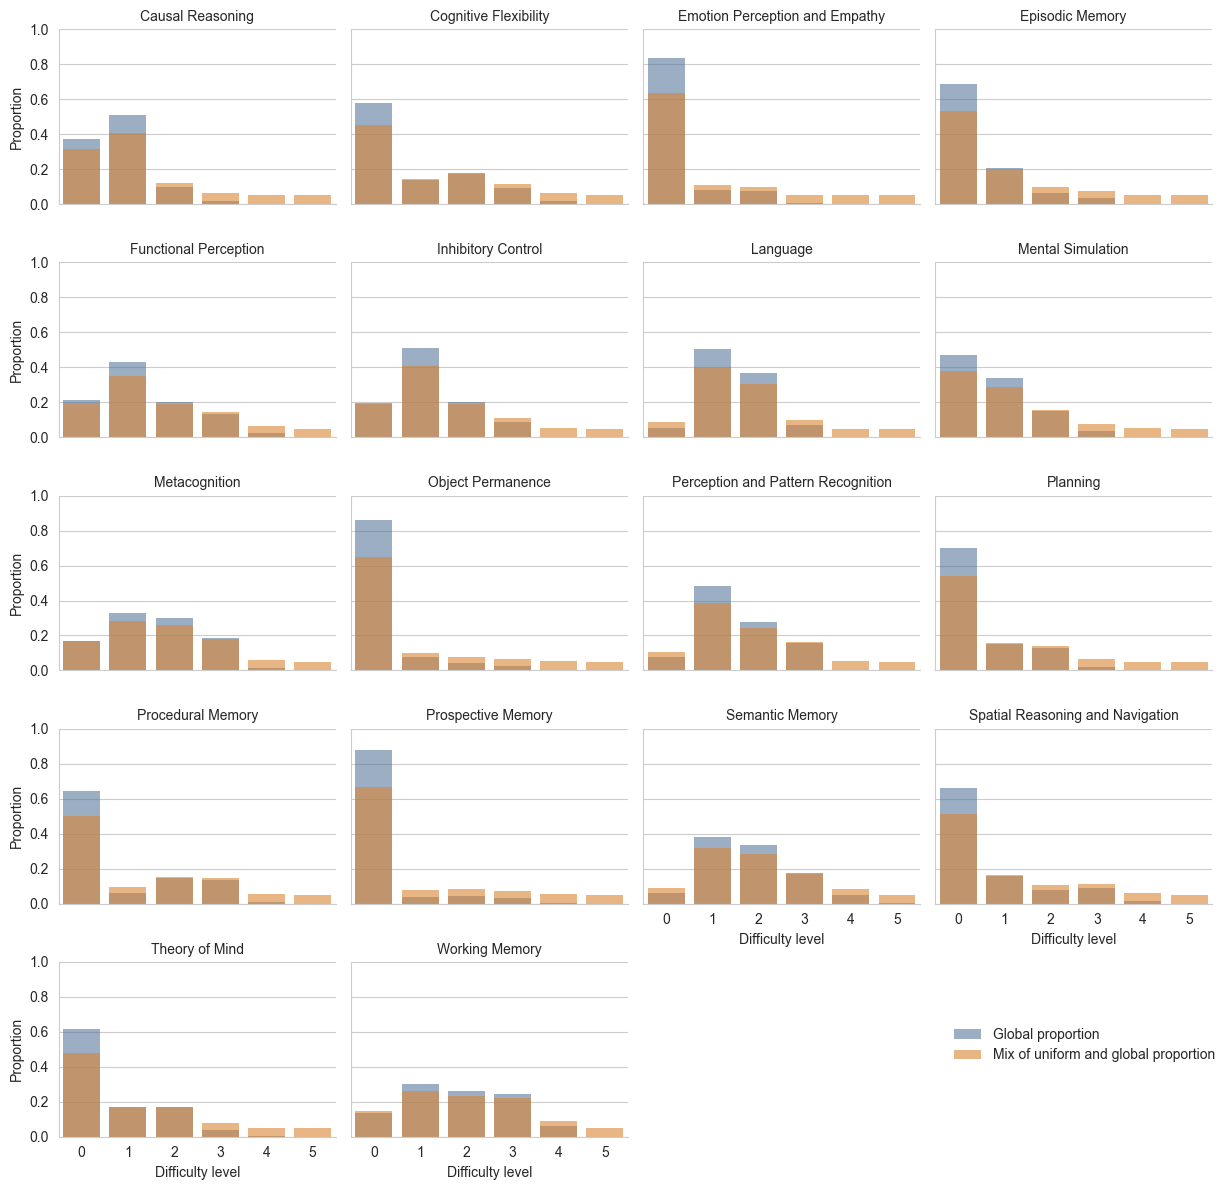

In [944]:
# Long-format for p_global
df_pg = p_global.reset_index().melt(id_vars="dimension", var_name="score", value_name="proportion")
df_pg["kind"] = "Global proportion"

# Long-format for mix
df_mix = pd.DataFrame(mix, index=p_global.index, columns=p_global.columns) \
    .reset_index().melt(id_vars="dimension", var_name="score", value_name="proportion")
df_mix["kind"] = "Mix of uniform and global proportion"

df_long = pd.concat([df_pg, df_mix], ignore_index=True)

g = sns.FacetGrid(df_long, col="dimension", col_wrap=4, row=None, height=2.4, sharey=True, sharex=True, hue="kind", palette={"Global proportion":"#4C78A8","Mix of uniform and global proportion":"#F58518"})
g.map_dataframe(sns.barplot, x="score", y="proportion", dodge=True, alpha=0.6, edgecolor="none")
g.add_legend(title="", loc="lower right", bbox_to_anchor=(1.0, 0.1))
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.set_ylim(0, 1)
    ax.set_xlabel("Difficulty level")
    ax.set_ylabel("Proportion")
plt.tight_layout()
plt.show()

In [945]:
T_cd.sum(axis=1)

dimension
Causal Reasoning                     20000.000000
Cognitive Flexibility                20000.000000
Emotion Perception and Empathy       20000.000000
Episodic Memory                      20000.000000
Functional Perception                20000.000000
Inhibitory Control                   20000.000000
Language                             20000.000000
Mental Simulation                    20000.000000
Metacognition                        20000.000000
Object Permanence                    20000.000000
Perception and Pattern Recognition   20000.000000
Planning                             20000.000000
Procedural Memory                    20000.000000
Prospective Memory                   20000.000000
Semantic Memory                      20000.000000
Spatial Reasoning and Navigation     20000.000000
Theory of Mind                       20000.000000
Working Memory                       20000.000000
dtype: float64

# Gaps $G_{c,d}$

$$
G_{c,d} = \max(T_{c,d} - A_{c,d}, 0).
$$

In [946]:
G_cd = (T_cd - A_cd).clip(lower=0)
G_cd

score,0,1,2,3,4,5
dimension,,,,,,
Causal Reasoning,4693.397313,5990.806142,1973.556622,1171.522073,1004.038388,1001.679463
Cognitive Flexibility,6672.535509,2339.190019,2728.412668,1888.635317,1202.188100,1004.038388
Emotion Perception and Empathy,9227.251440,1815.508637,1716.433781,1070.088292,1004.038388,1001.679463
Episodic Memory,7755.282150,3046.867562,1657.460653,1357.877159,1013.474088,1004.038388
Functional Perception,3079.892514,5226.514395,2983.176583,2310.882917,1228.136276,1006.397313
Inhibitory Control,2954.869482,6028.548944,2971.381958,1853.251440,1025.268714,1001.679463
Language,1541.873321,5976.652591,4594.322457,1716.433781,1004.038388,1001.679463
Mental Simulation,5615.737044,4332.481766,2506.673704,1367.312860,1011.115163,1001.679463
Metacognition,2657.644914,4252.278311,3973.925144,2810.975048,1136.138196,1004.038388


In [947]:
A_cd.sum(axis=1)

dimension
Causal Reasoning                      4165
Cognitive Flexibility                 4165
Emotion Perception and Empathy        4165
Episodic Memory                       4165
Functional Perception                 4165
Inhibitory Control                    4165
Language                              4165
Mental Simulation                     4165
Metacognition                         4165
Object Permanence                     4165
Perception and Pattern Recognition    4165
Planning                              4164
Procedural Memory                     4165
Prospective Memory                    4165
Semantic Memory                       4165
Spatial Reasoning and Navigation      4165
Theory of Mind                        4165
Working Memory                        4164
dtype: int64

In [948]:
G_cd.sum(axis=1)

dimension
Causal Reasoning                     15835.000000
Cognitive Flexibility                15835.000000
Emotion Perception and Empathy       15835.000000
Episodic Memory                      15835.000000
Functional Perception                15835.000000
Inhibitory Control                   15835.000000
Language                             15835.000000
Mental Simulation                    15835.000000
Metacognition                        15835.000000
Object Permanence                    15835.000000
Perception and Pattern Recognition   15835.000000
Planning                             15836.000000
Procedural Memory                    15835.000000
Prospective Memory                   15835.000000
Semantic Memory                      15835.000000
Spatial Reasoning and Navigation     15835.000000
Theory of Mind                       15835.000000
Working Memory                       15836.000000
dtype: float64

# Per-dataset proportions $\hat p_{b,c,d}$ and shrinkage $\tilde p_{b,c,d}$

## Proportion of items in dataset $b$ in capability $c$ in difficulty bin $d$

$\hat p_{b,c,d}$ is the probability that one item from dataset $b$ lands in bin $(c,d)$ for capability $c$.
Laplace smoothed (small regularisation to avoid issues when the pilot count for that particular bin is zero):

$$
\hat p_{b,c,d} = \frac{n_{b,c,d}+\epsilon}{m_{b}+|D| \cdot \epsilon}.
$$

In [949]:
datasets = sorted(items_per_dataset.index.tolist())
p_bcd = {b: pd.DataFrame(0.0, index=capabilities, columns=SCORE_BINS) for b in datasets}
m_b_cap = {b: pd.Series(0, index=capabilities, dtype=int) for b in datasets}
m_b_cap

{'AGIEval_freeform_annotations': Causal Reasoning                      0
 Cognitive Flexibility                 0
 Emotion Perception and Empathy        0
 Episodic Memory                       0
 Functional Perception                 0
 Inhibitory Control                    0
 Language                              0
 Mental Simulation                     0
 Metacognition                         0
 Object Permanence                     0
 Perception and Pattern Recognition    0
 Planning                              0
 Procedural Memory                     0
 Prospective Memory                    0
 Semantic Memory                       0
 Spatial Reasoning and Navigation      0
 Theory of Mind                        0
 Working Memory                        0
 dtype: int64,
 'AGIEval_mcq_annotations': Causal Reasoning                      0
 Cognitive Flexibility                 0
 Emotion Perception and Empathy        0
 Episodic Memory                       0
 Functional Perception  

Each dataset $b$ is summarised by $\hat p_{b,c,d}$: the estimated probability an item lands in each capability×difficulty bin

In [950]:
#proportions per dataset, capability and difficulty
for b in datasets:
    sub = data[data["dataset name"]==b]
    counts_b = (sub.groupby(["dimension","score"]).size()
                   .unstack(fill_value=0)
                   .reindex(index=capabilities, columns=SCORE_BINS, fill_value=0))
    m_b = counts_b.sum(axis=1)
    m_b_cap[b] = m_b
    p_hat = (counts_b + eps).div((m_b + eps*len(SCORE_BINS)), axis=0) #Laplace smoothing
    p_bcd[b] = p_hat

In [951]:
p_bcd

{'AGIEval_freeform_annotations': score                                     0        1        2        3  \
 dimension                                                                
 Causal Reasoning                   0.948276 0.022167 0.022167 0.002463   
 Cognitive Flexibility              0.613300 0.051724 0.214286 0.096059   
 Emotion Perception and Empathy     0.987685 0.002463 0.002463 0.002463   
 Episodic Memory                    0.987685 0.002463 0.002463 0.002463   
 Functional Perception              0.455665 0.125616 0.317734 0.096059   
 Inhibitory Control                 0.110837 0.613300 0.219212 0.046798   
 Language                           0.347291 0.500000 0.105911 0.041872   
 Mental Simulation                  0.716749 0.110837 0.155172 0.012315   
 Metacognition                      0.081281 0.312808 0.327586 0.263547   
 Object Permanence                  0.982759 0.002463 0.007389 0.002463   
 Perception and Pattern Recognition 0.115764 0.199507 0.431034 0.238

## Shrinkage

Pilot data may be noisy as we have 18 capabilities and 6 difficulty levels. Idea is to borrow strength from the global proportion (a form of Bayesian smoothing or shrinkage where we pull the local distribution toward the global distribution):

$$
\tilde p_{b,c,d} = \frac{m_{b}\hat p_{b,c,d} + K\,p_{\text{global},c}}{m_{b}+K}.
$$

- $m_{b,c}$ is the amount of data observed for capability $c$ in dataset $b$.
- $K$ is the prior strength: large $K$ → more pull toward the global distribution; small $K$ → let the dataset’s own data dominate.

If pilots are noisy / heavy tails / many zero bins → push to $\tau\in[0.2,0.3] ⇒ K\in[50,85]$.
If pilots look stable and large (few zeros, consistent across datasets) → $\tau\in[0.1,0.15] ⇒ K\in[22,35]$. Where the “prior weight” (shrinkage fraction)
$\tau \;=\; \frac{K}{m_{b}+K}$.

In [952]:
tau = 0.20
tilde_p = {b: pd.DataFrame(0.0, index=capabilities, columns=SCORE_BINS) for b in datasets}

for b in datasets:
    m_vec = m_b_cap[b].astype(float)                   # per-capability counts m_{b,c}
    K_row = (tau / (1 - tau)) * m_vec                  # K_{b,c}

    # Numerator and denominator; broadcast per row (axis=0)
    num   = p_bcd[b].multiply(m_vec, axis=0) + p_global.multiply(K_row, axis=0)
    denom = (m_vec + K_row)

    # Avoid divide-by-zero: if m_{b,c}=0 => denom=0, fallback to p_global row
    shrunk = num.div(denom, axis=0)

    # tiny renorm (floating-point guard)
    shrunk = shrunk.div(shrunk.sum(axis=1), axis=0)

    tilde_p[b] = shrunk


In [953]:
tilde_p

{'AGIEval_freeform_annotations': score                                     0        1        2        3  \
 dimension                                                                
 Causal Reasoning                   0.833741 0.119246 0.037528 0.005449   
 Cognitive Flexibility              0.606019 0.068611 0.206577 0.094914   
 Emotion Perception and Empathy     0.957494 0.018549 0.016534 0.003386   
 Episodic Memory                    0.927552 0.043597 0.015334 0.009240   
 Functional Perception              0.406830 0.186457 0.294518 0.103503   
 Inhibitory Control                 0.128425 0.592920 0.215461 0.054785   
 Language                           0.288845 0.501224 0.157834 0.048061   
 Mental Simulation                  0.667281 0.156448 0.154776 0.017314   
 Metacognition                      0.098734 0.316393 0.322554 0.247666   
 Object Permanence                  0.957824 0.016918 0.014045 0.006889   
 Perception and Pattern Recognition 0.108278 0.255839 0.400034 0.222

In [954]:
def _stack_dict_of_frames(dct, value_col):
    frames = []
    for b, df in dct.items():
        f = (df.rename_axis(index="capability", columns="difficulty")
               .stack()
               .rename(value_col)
               .to_frame()
               .reset_index())
        f["dataset"] = b
        frames.append(f)
    return pd.concat(frames, ignore_index=True)

df_hat   = _stack_dict_of_frames(p_bcd,   "p_hat")
df_tilde = _stack_dict_of_frames(tilde_p, "p_tilde")

df_diff = (df_hat
      .merge(df_tilde, on=["dataset","capability","difficulty"], how="inner")
      .assign(delta=lambda x: x["p_tilde"] - x["p_hat"],
              abs_delta=lambda x: x["delta"].abs()))

In [955]:
df_diff.head()

,capability,difficulty,p_hat,dataset,p_tilde,delta,abs_delta
0,Causal Reasoning,0,0.948276,AGIEval_freeform_annotations,0.833741,-0.114535,0.114535
1,Causal Reasoning,1,0.022167,AGIEval_freeform_annotations,0.119246,0.097078,0.097078
2,Causal Reasoning,2,0.022167,AGIEval_freeform_annotations,0.037528,0.015360,0.015360
3,Causal Reasoning,3,0.002463,AGIEval_freeform_annotations,0.005449,0.002986,0.002986
4,Causal Reasoning,4,0.002463,AGIEval_freeform_annotations,0.002042,-0.000421,0.000421


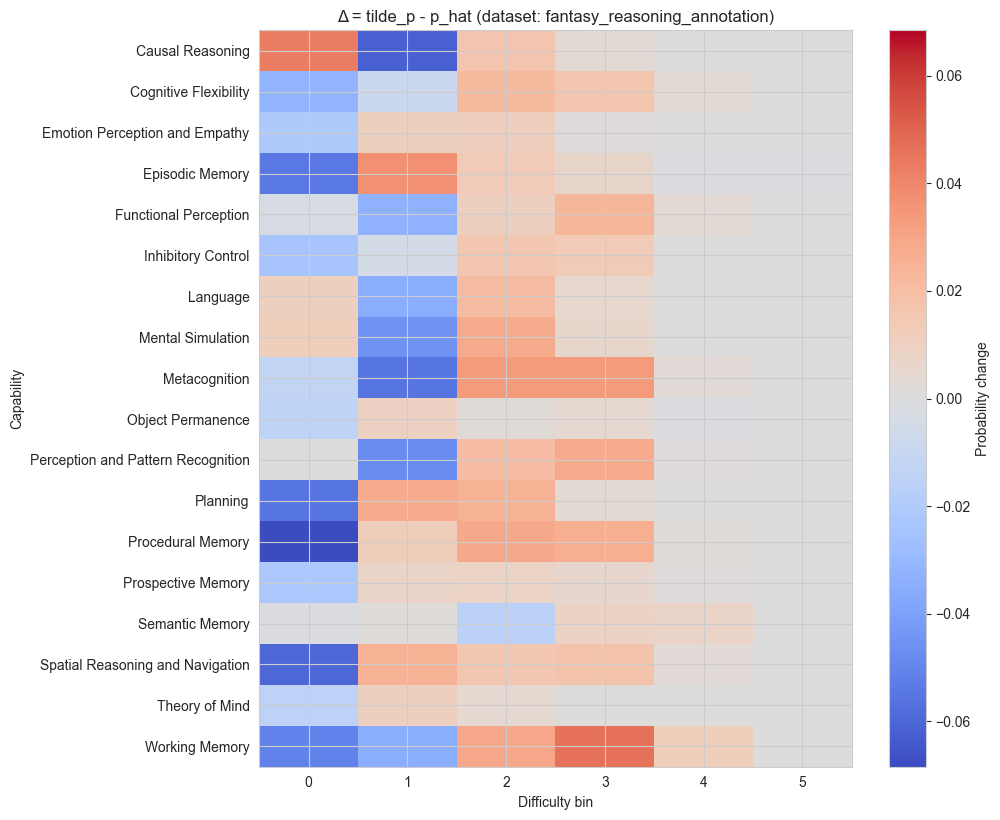

In [956]:
def plot_delta_heatmap(df, dataset, vlim=None):
    data = (df.query("dataset == @dataset")
              .pivot(index="capability", columns="difficulty", values="delta")
              .reindex(index=capabilities, columns=SCORE_BINS))  # consistent ordering

    if vlim is None:
        vmax_abs = float(np.nanmax(np.abs(data.values))) if data.size else 0.0
        vlim = max(vmax_abs, 1e-6)

    fig, ax = plt.subplots(figsize=(1.2*len(SCORE_BINS)+3, 0.35*len(capabilities)+2))
    im = ax.imshow(data.values, aspect="auto", vmin=-vlim, vmax=vlim, cmap="coolwarm")
    ax.set_xticks(range(len(SCORE_BINS))); ax.set_xticklabels(SCORE_BINS)
    ax.set_yticks(range(len(capabilities))); ax.set_yticklabels(capabilities)
    ax.set_xlabel("Difficulty bin"); ax.set_ylabel("Capability")
    ax.set_title(f"Δ = tilde_p - p_hat (dataset: {dataset})")
    cb = fig.colorbar(im, ax=ax); cb.set_label("Probability change")
    plt.tight_layout(); plt.show()

# Example: pick one dataset
plot_delta_heatmap(df_diff, datasets[16])

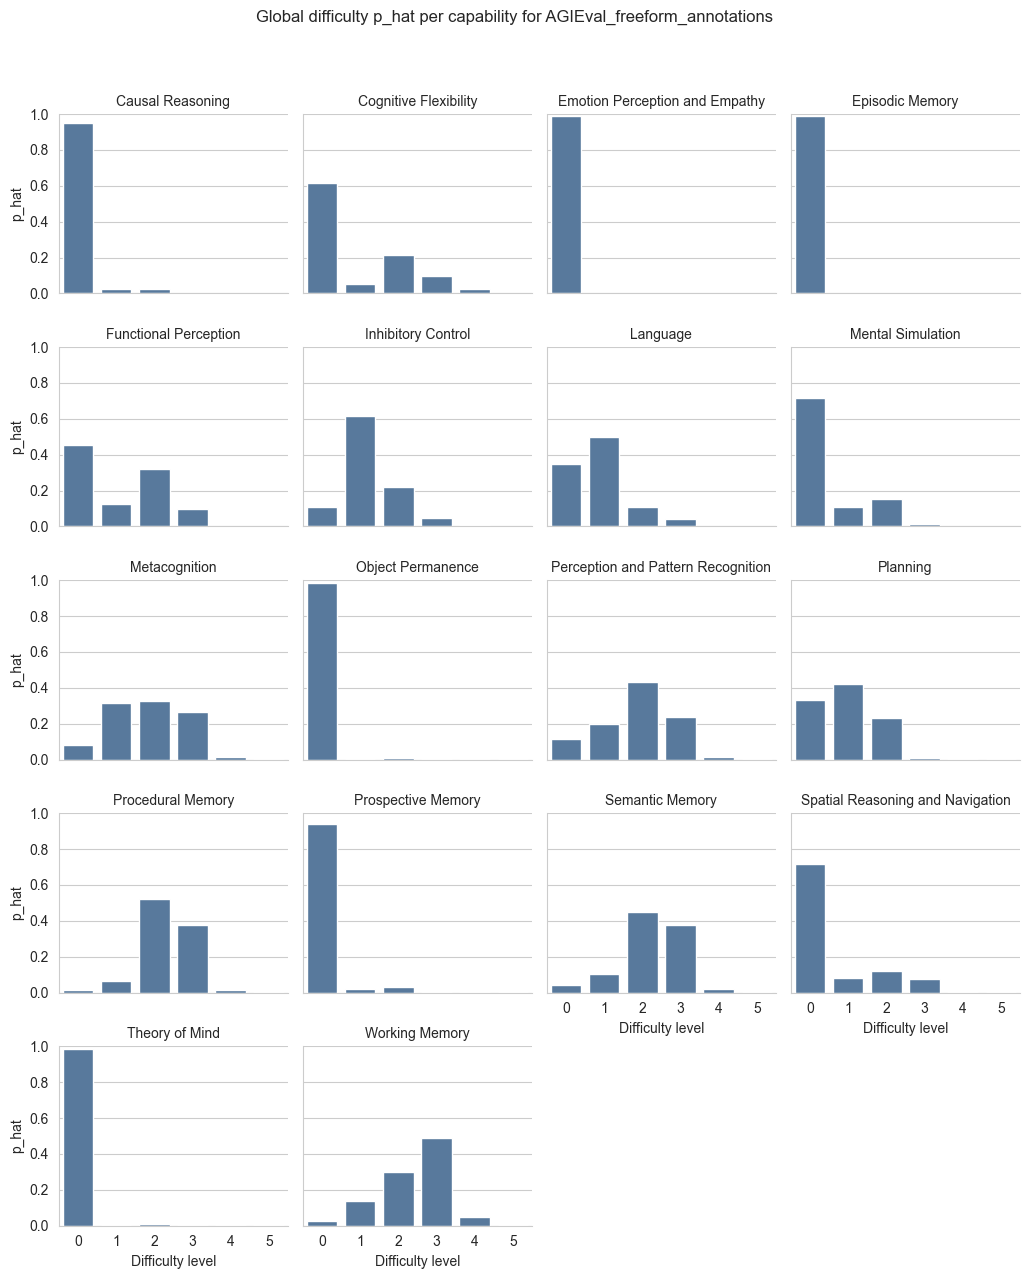

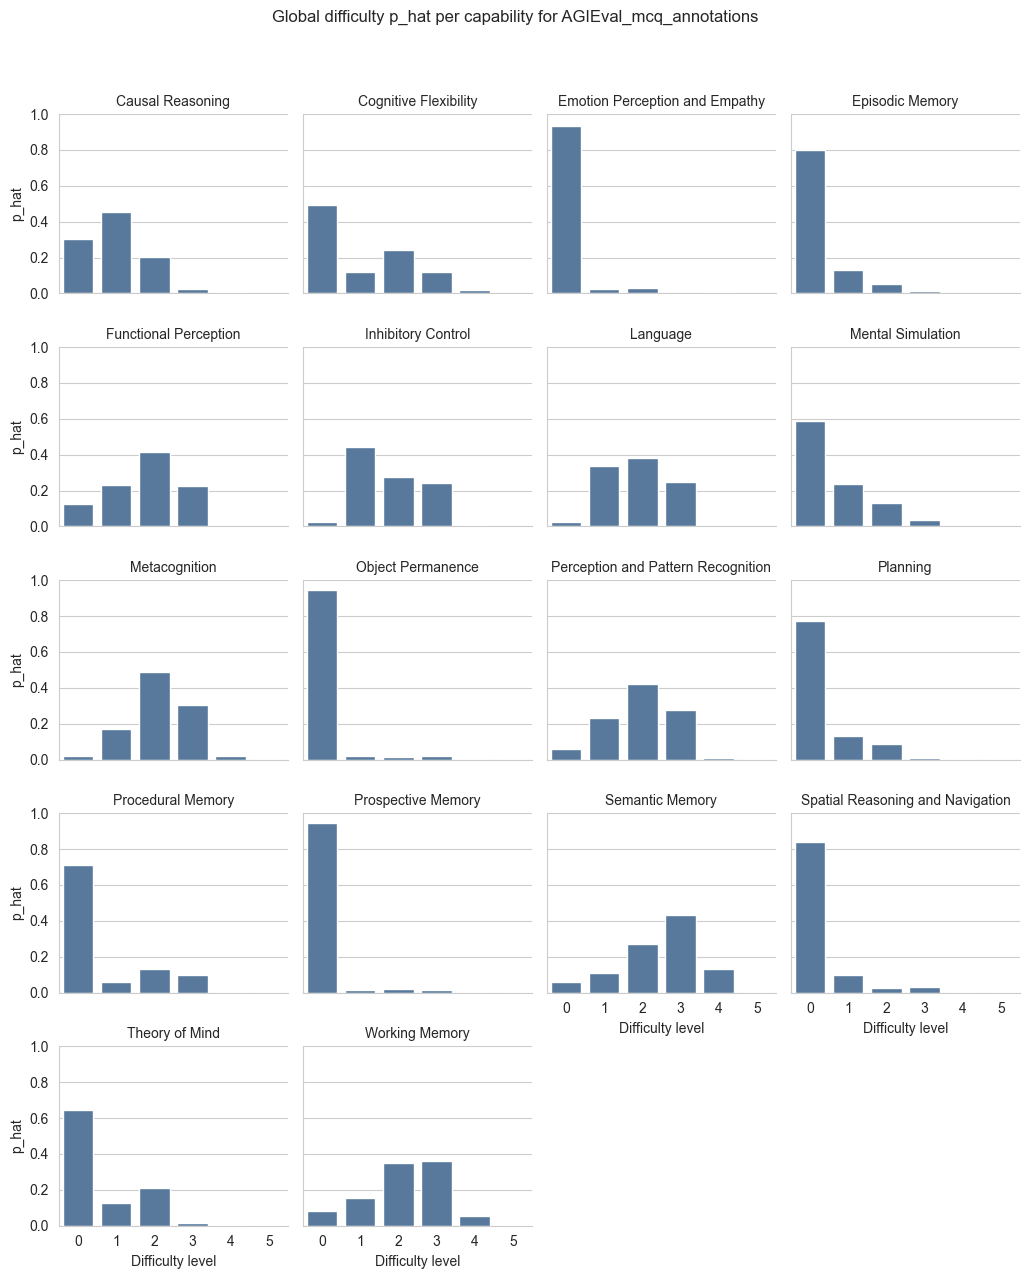

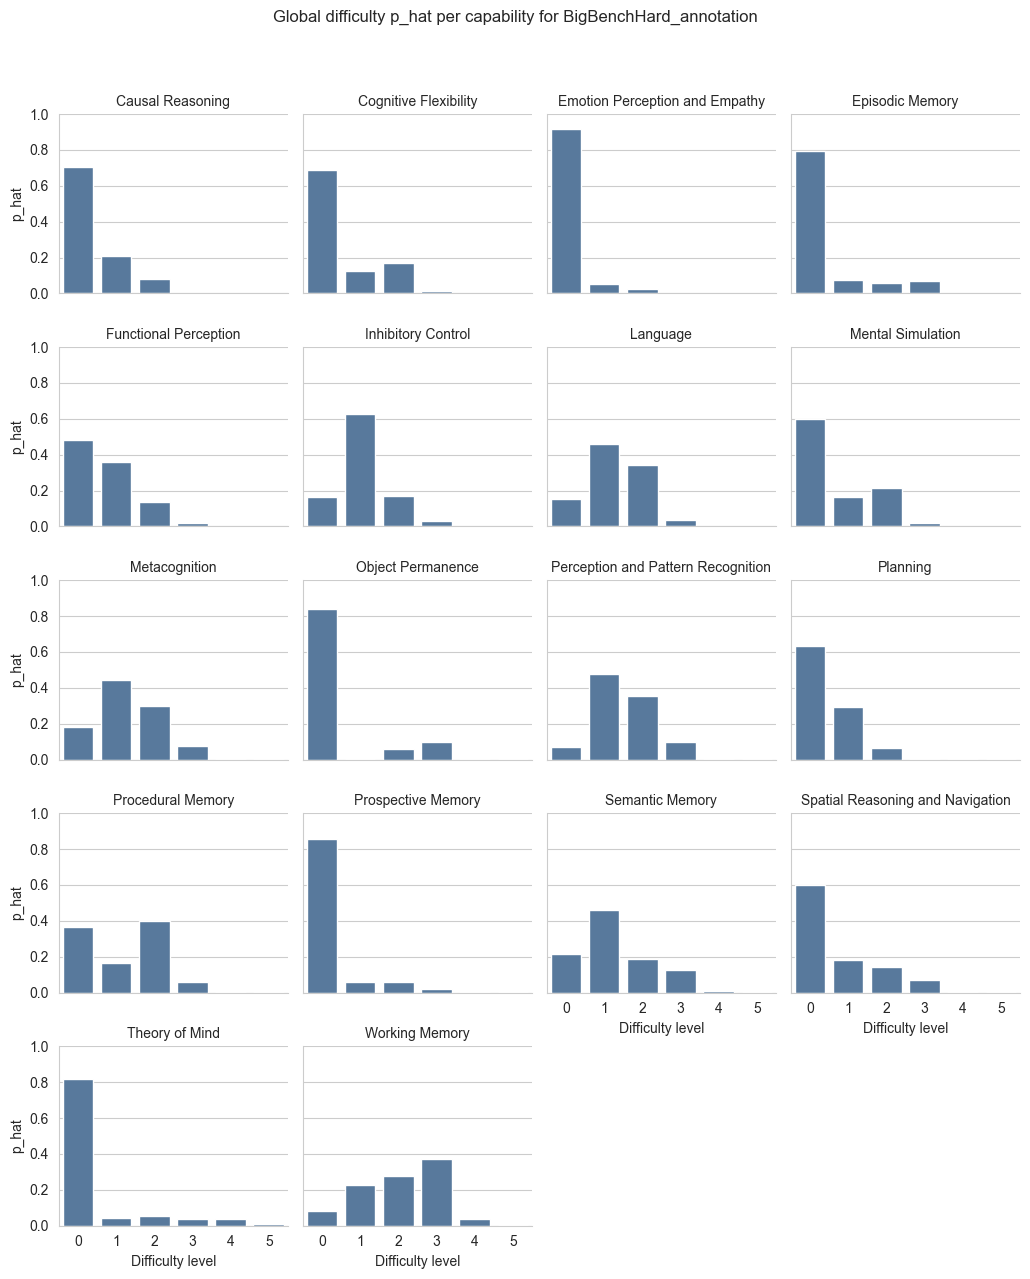

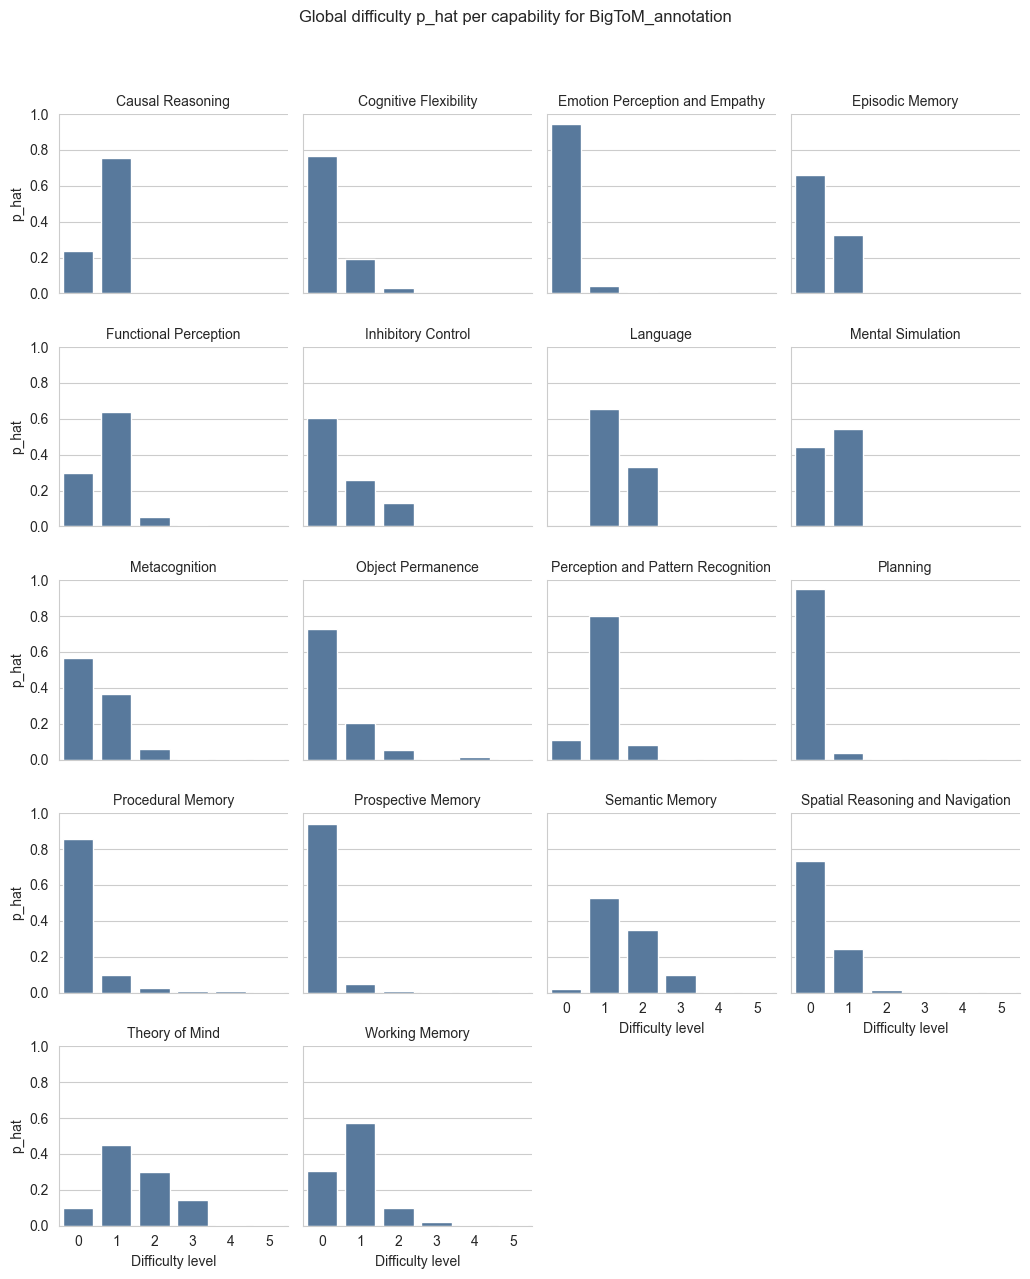

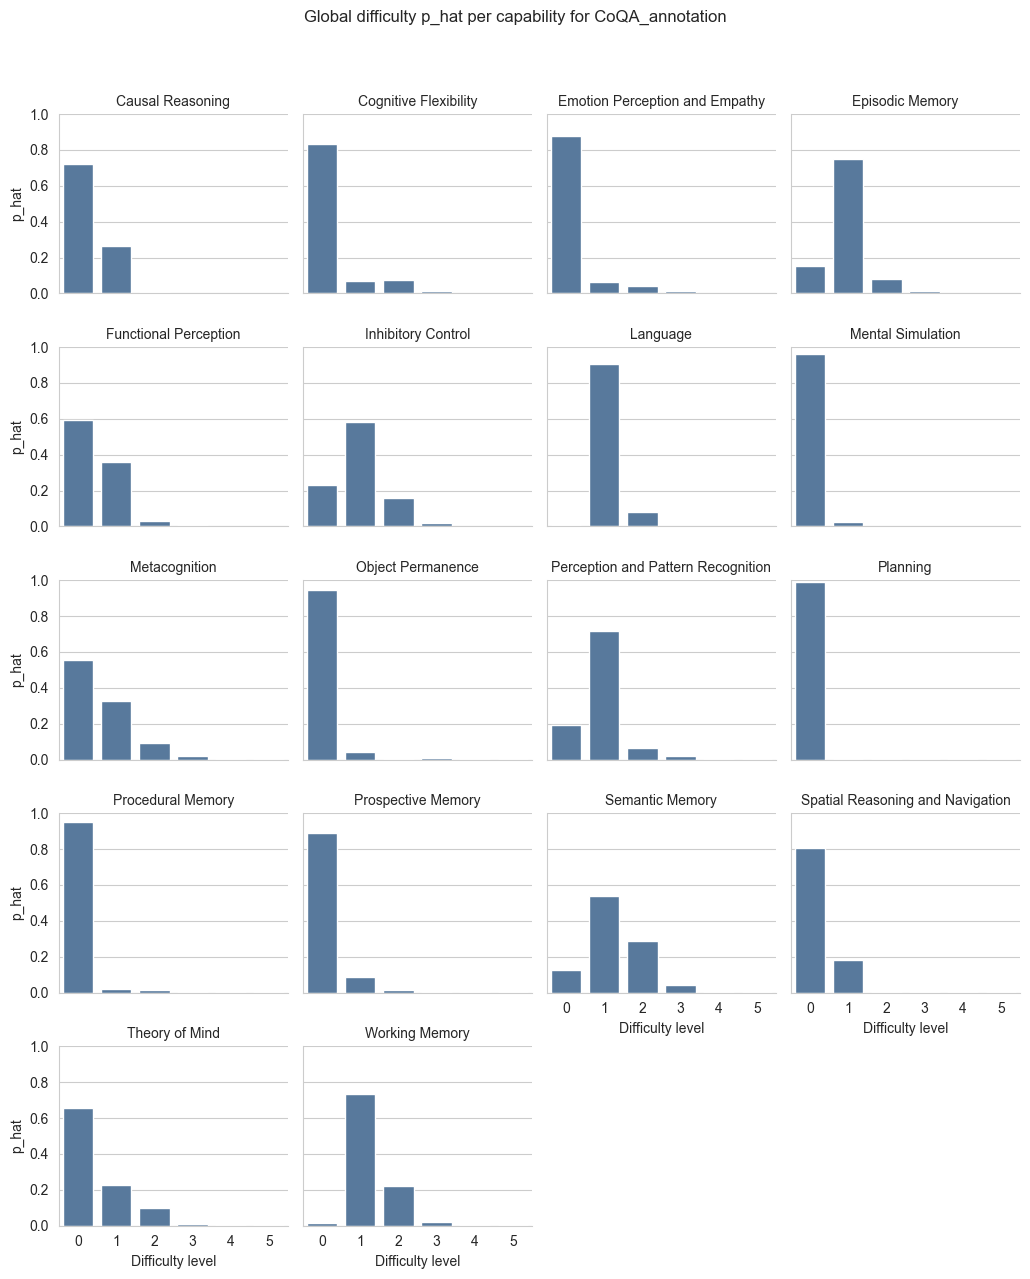

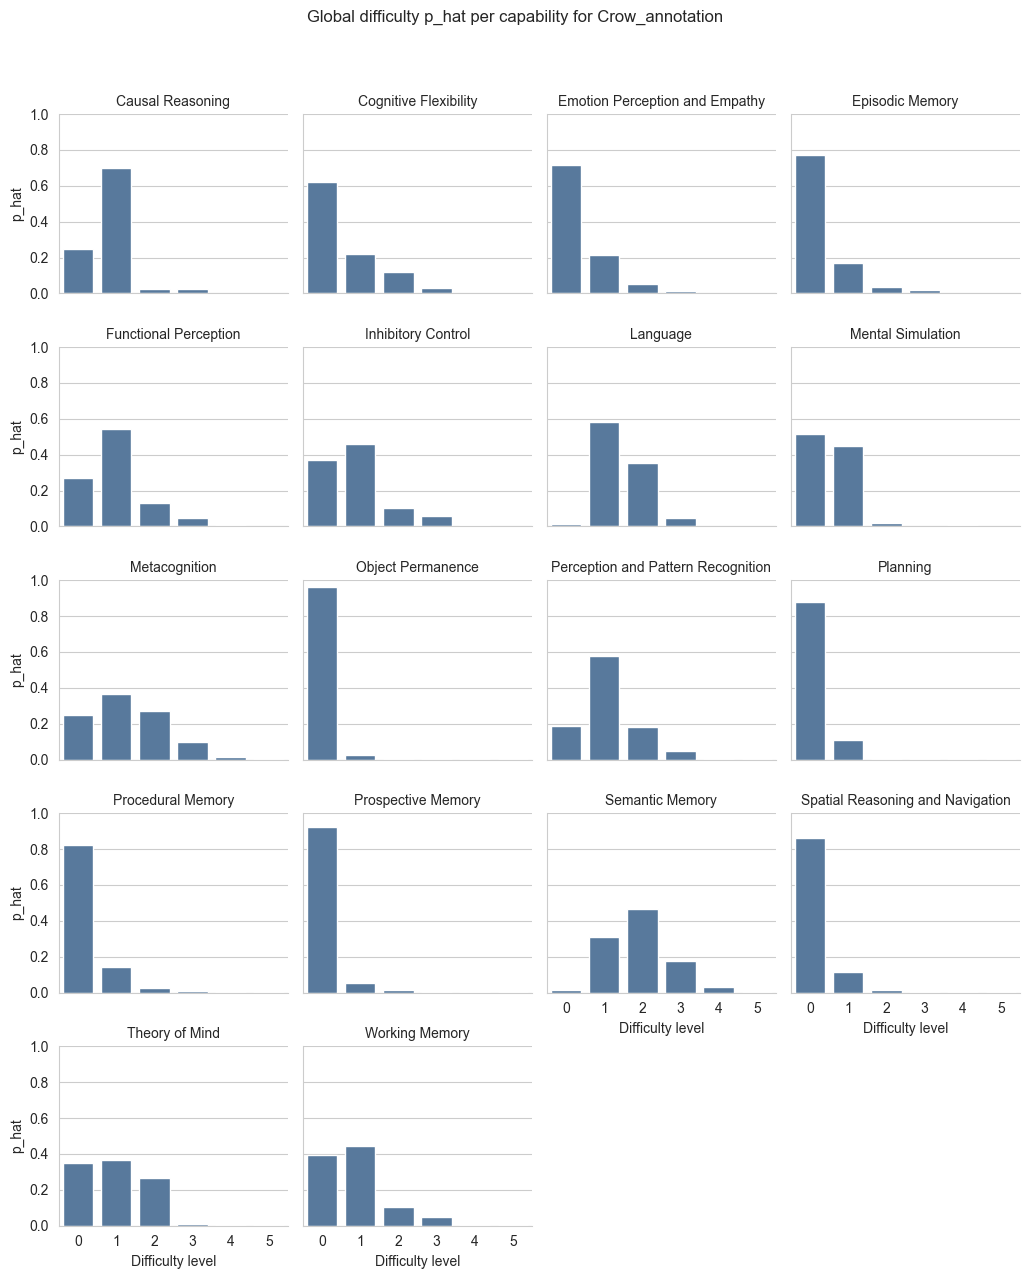

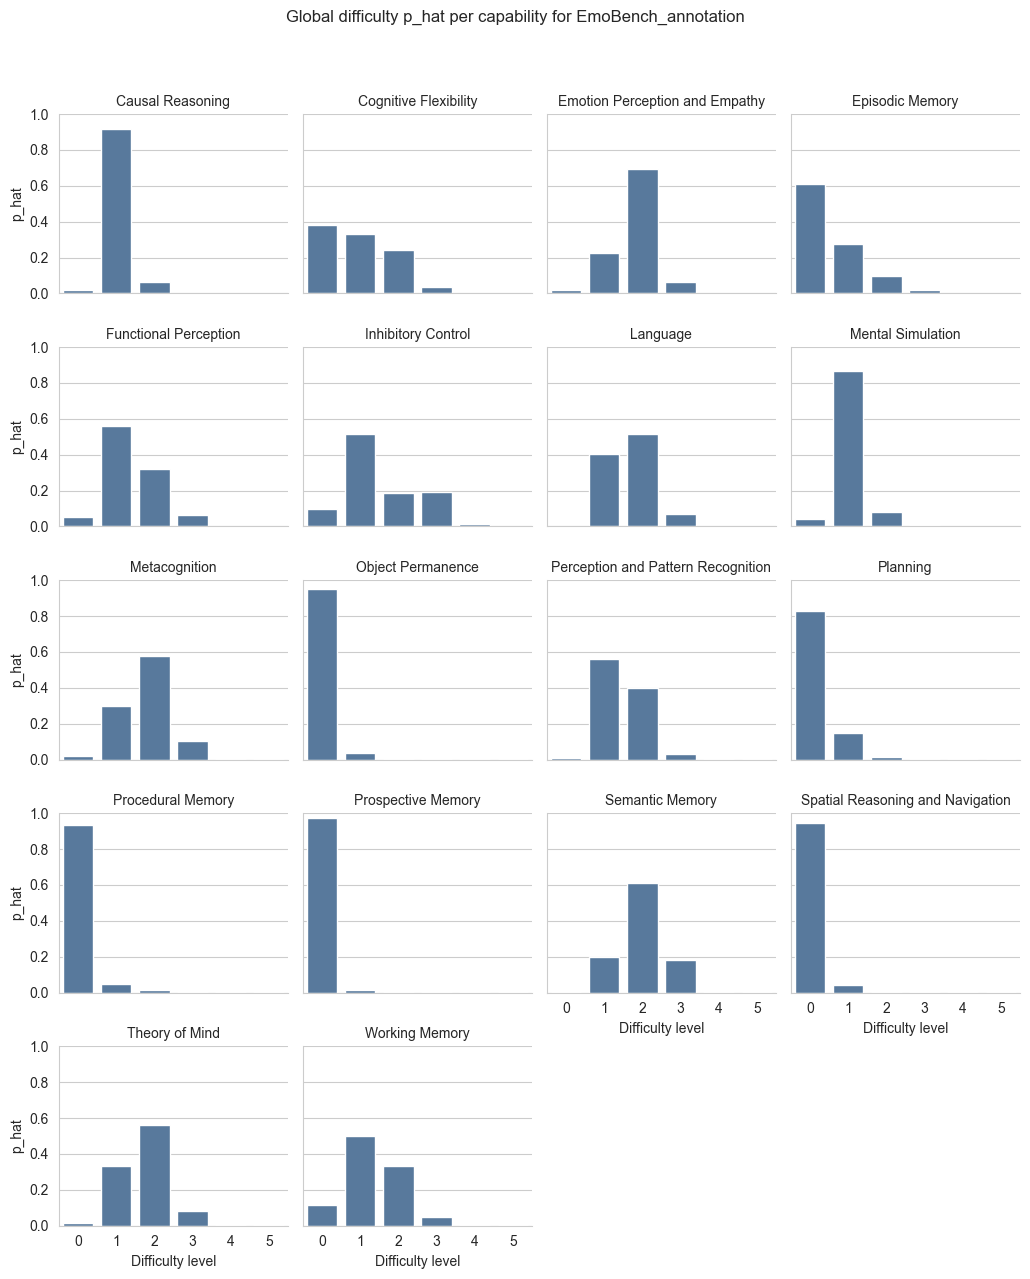

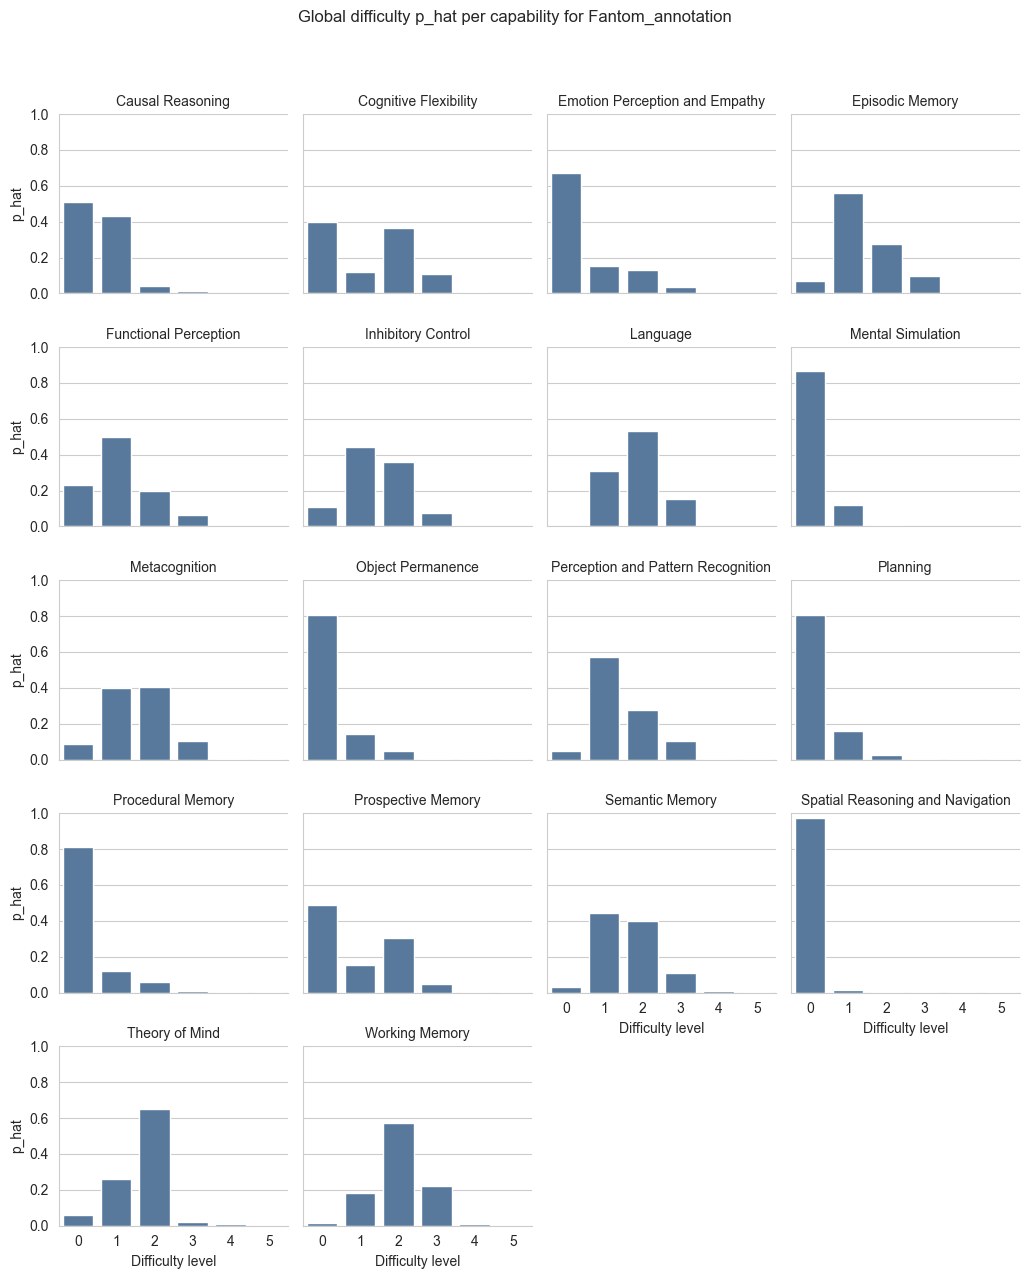

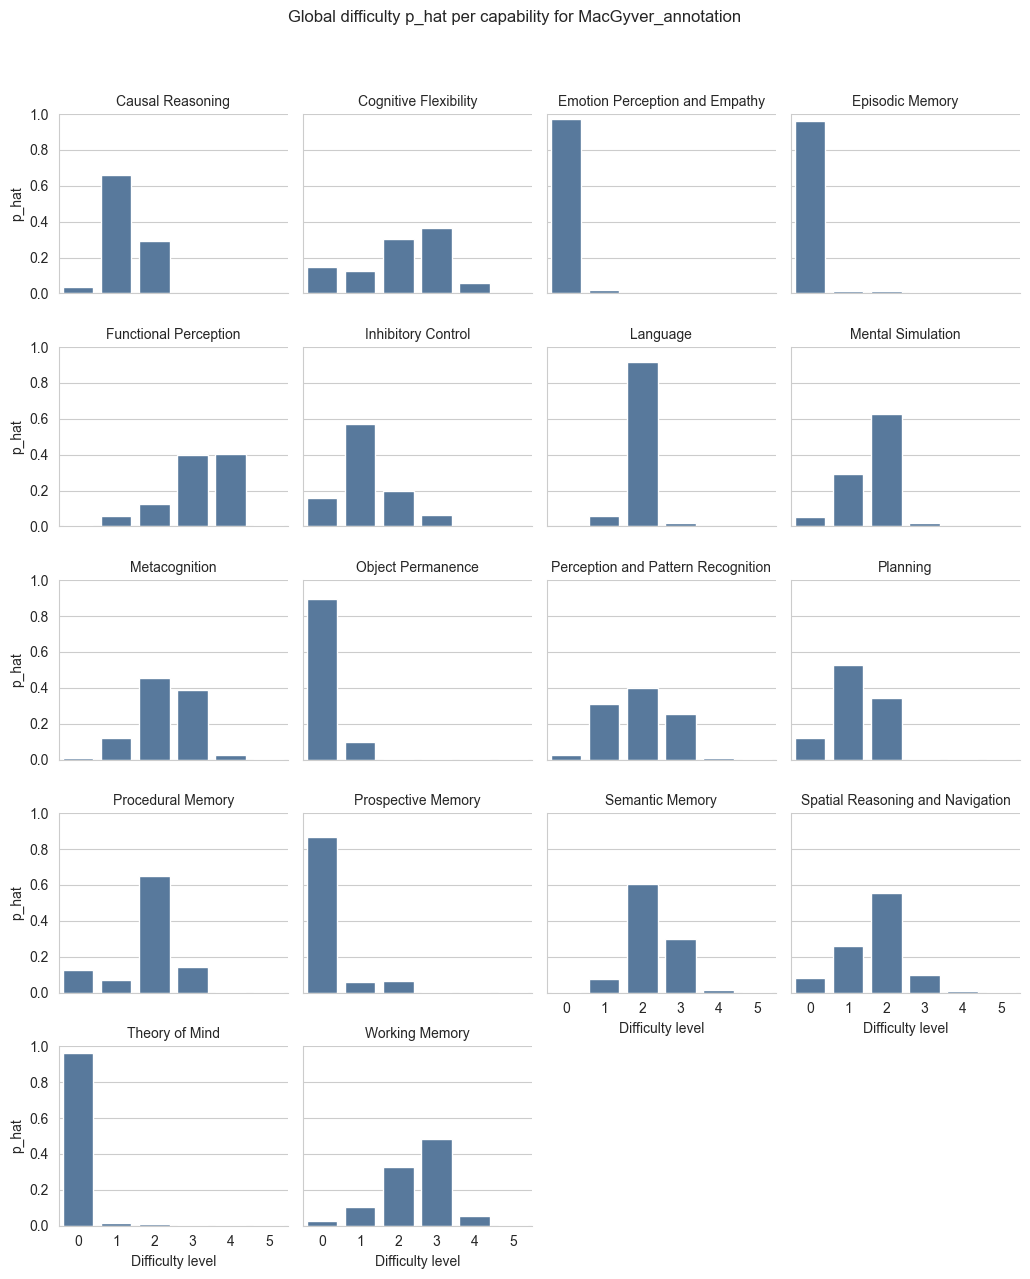

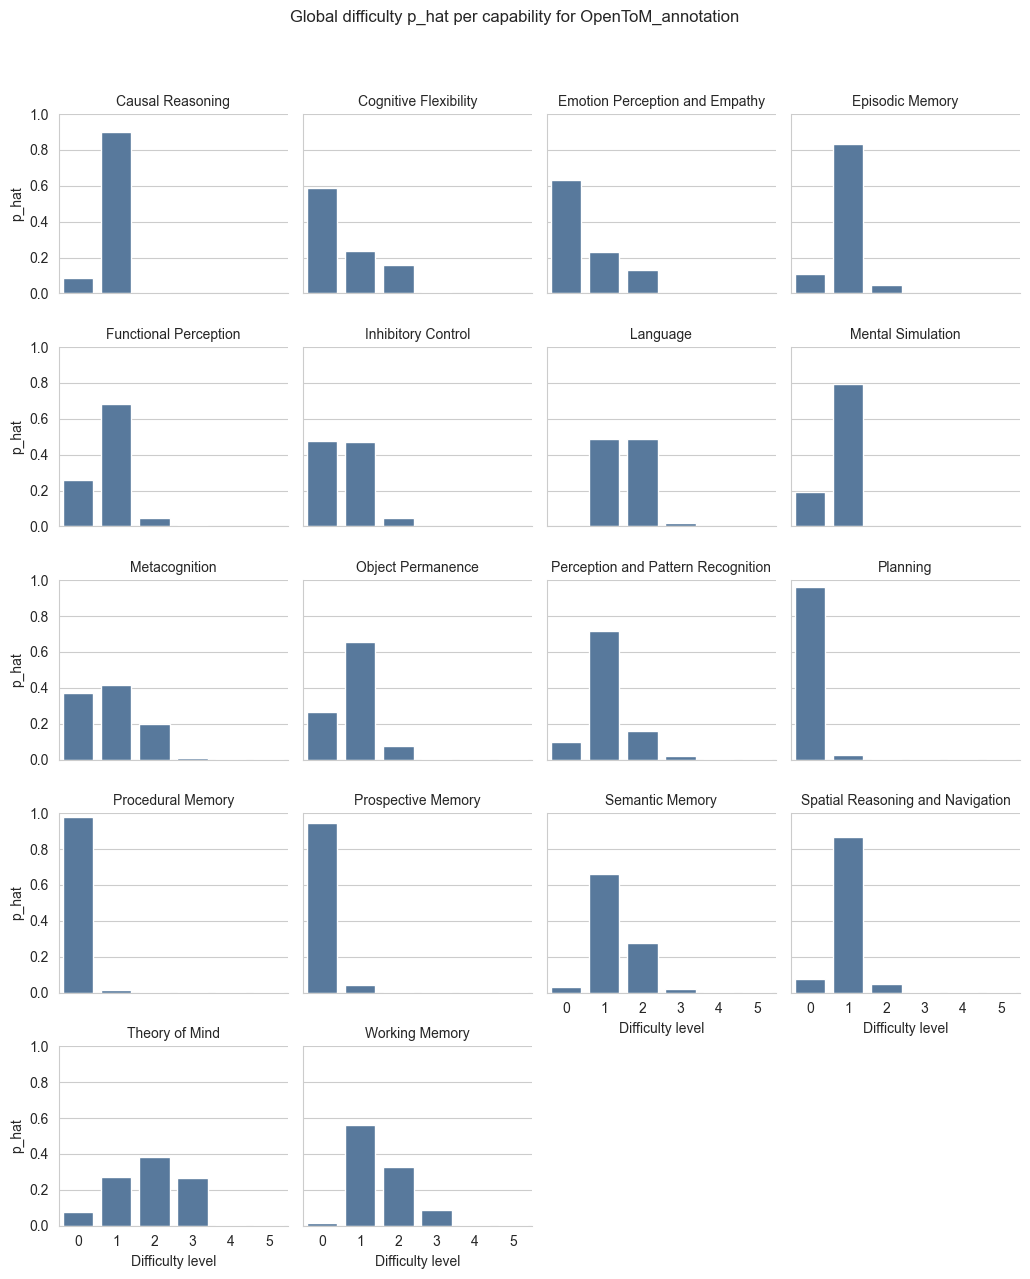

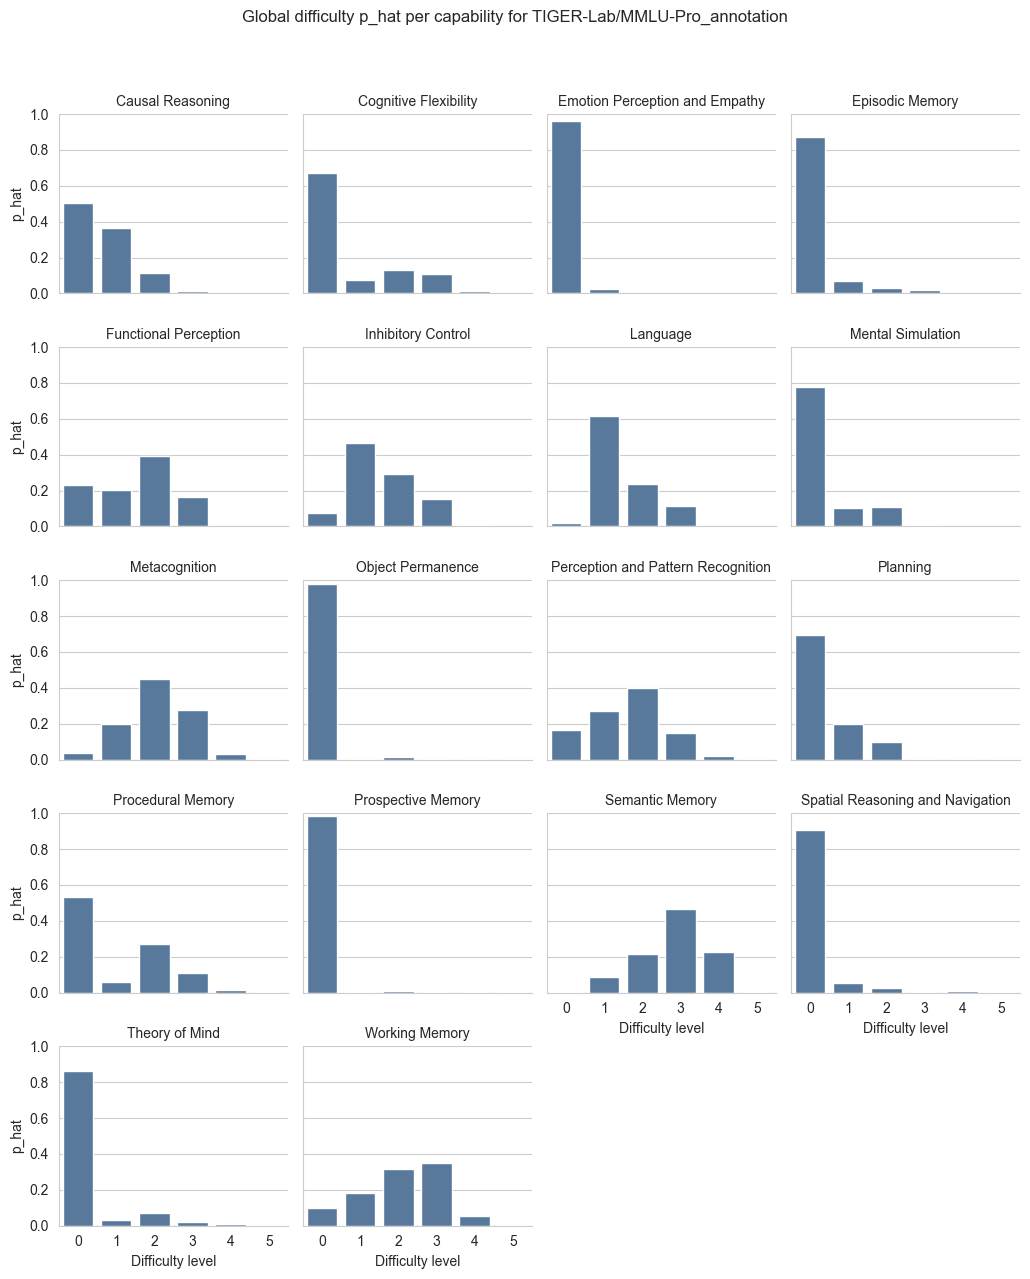

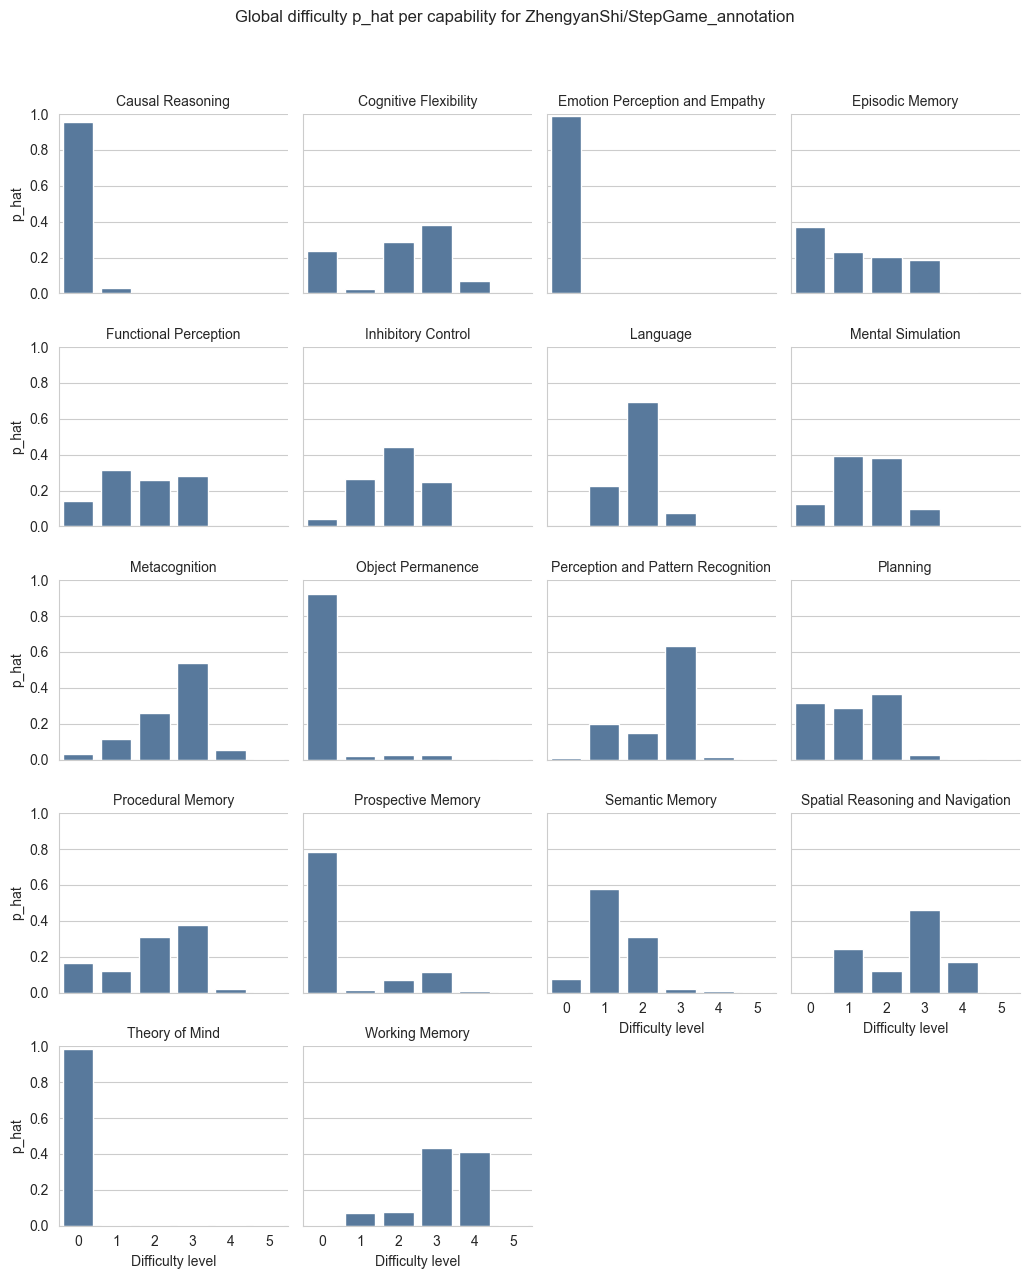

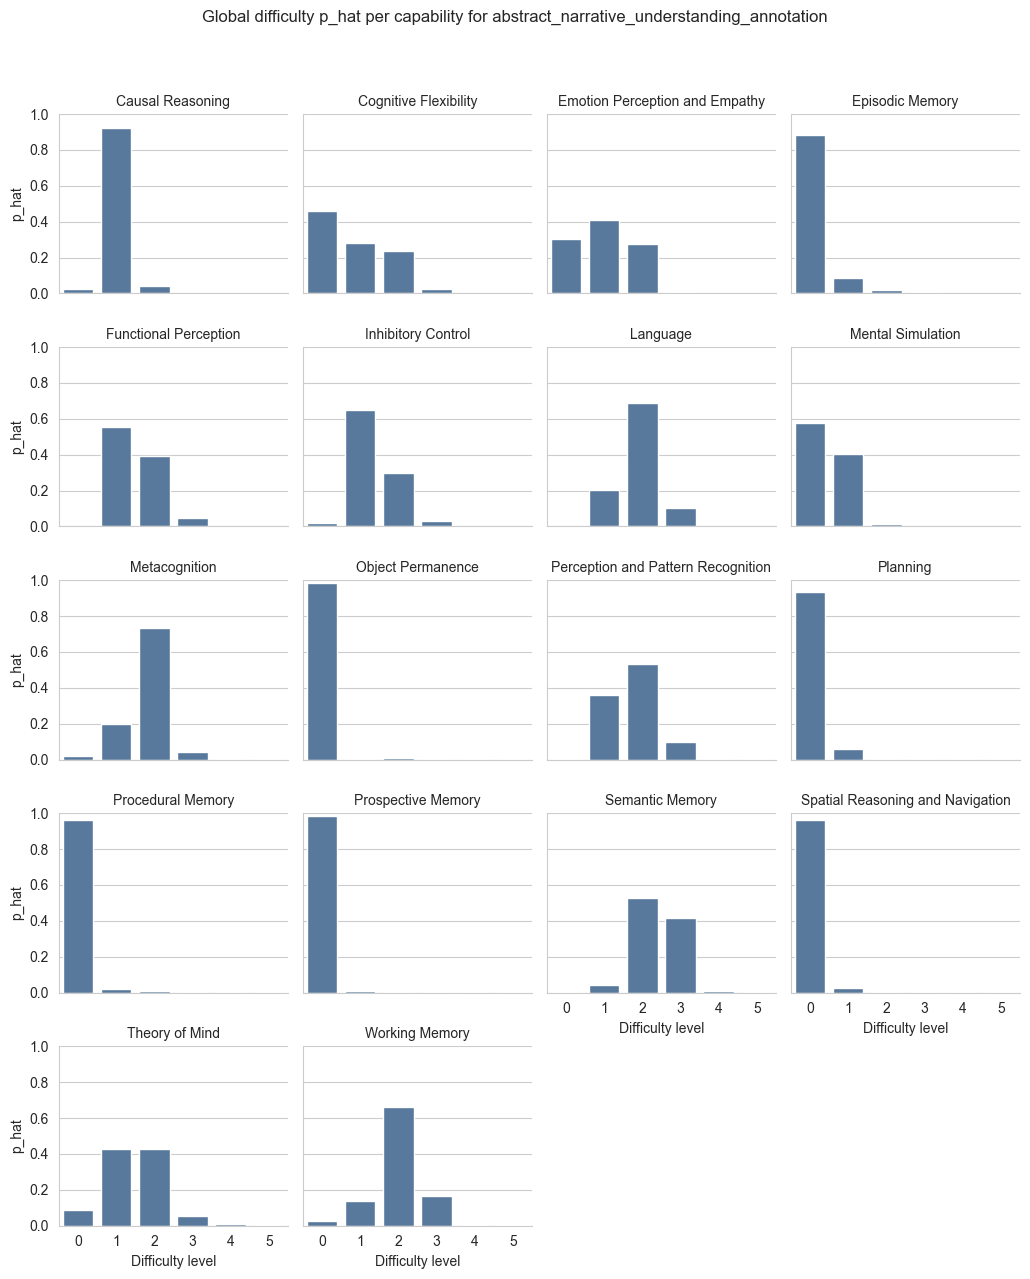

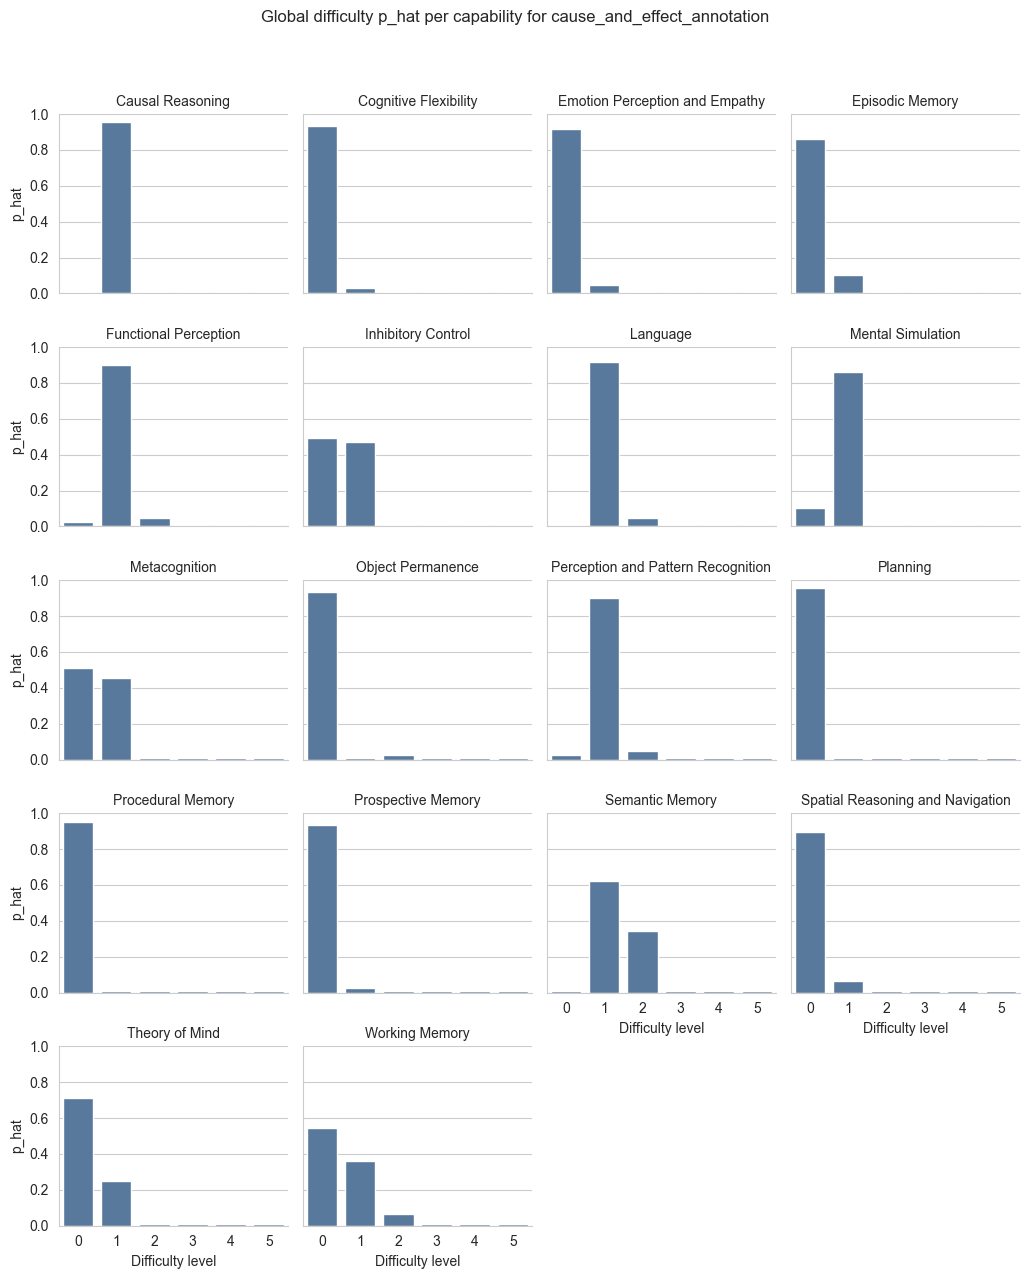

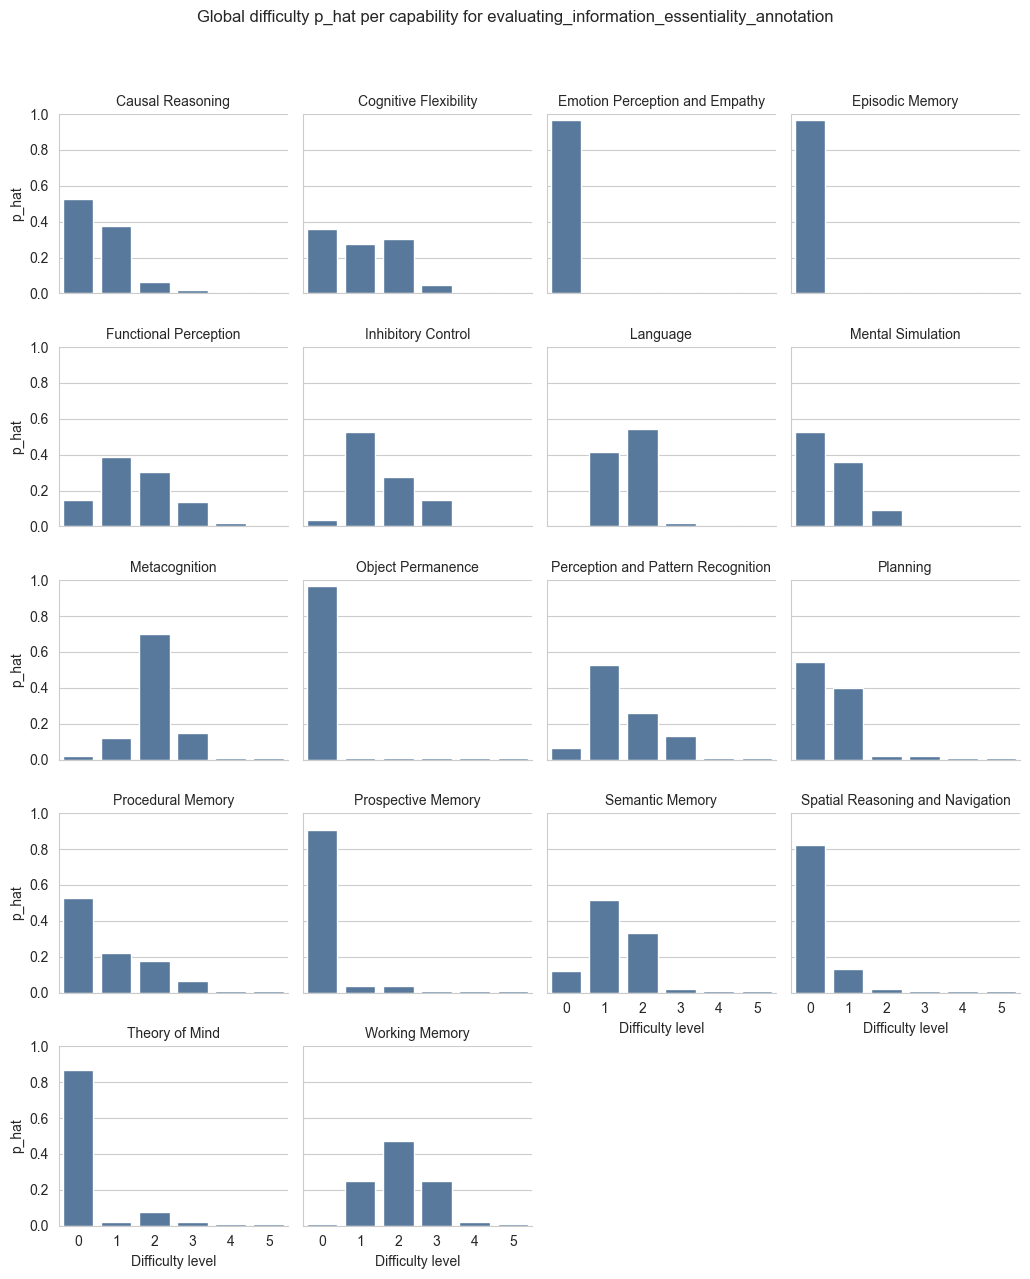

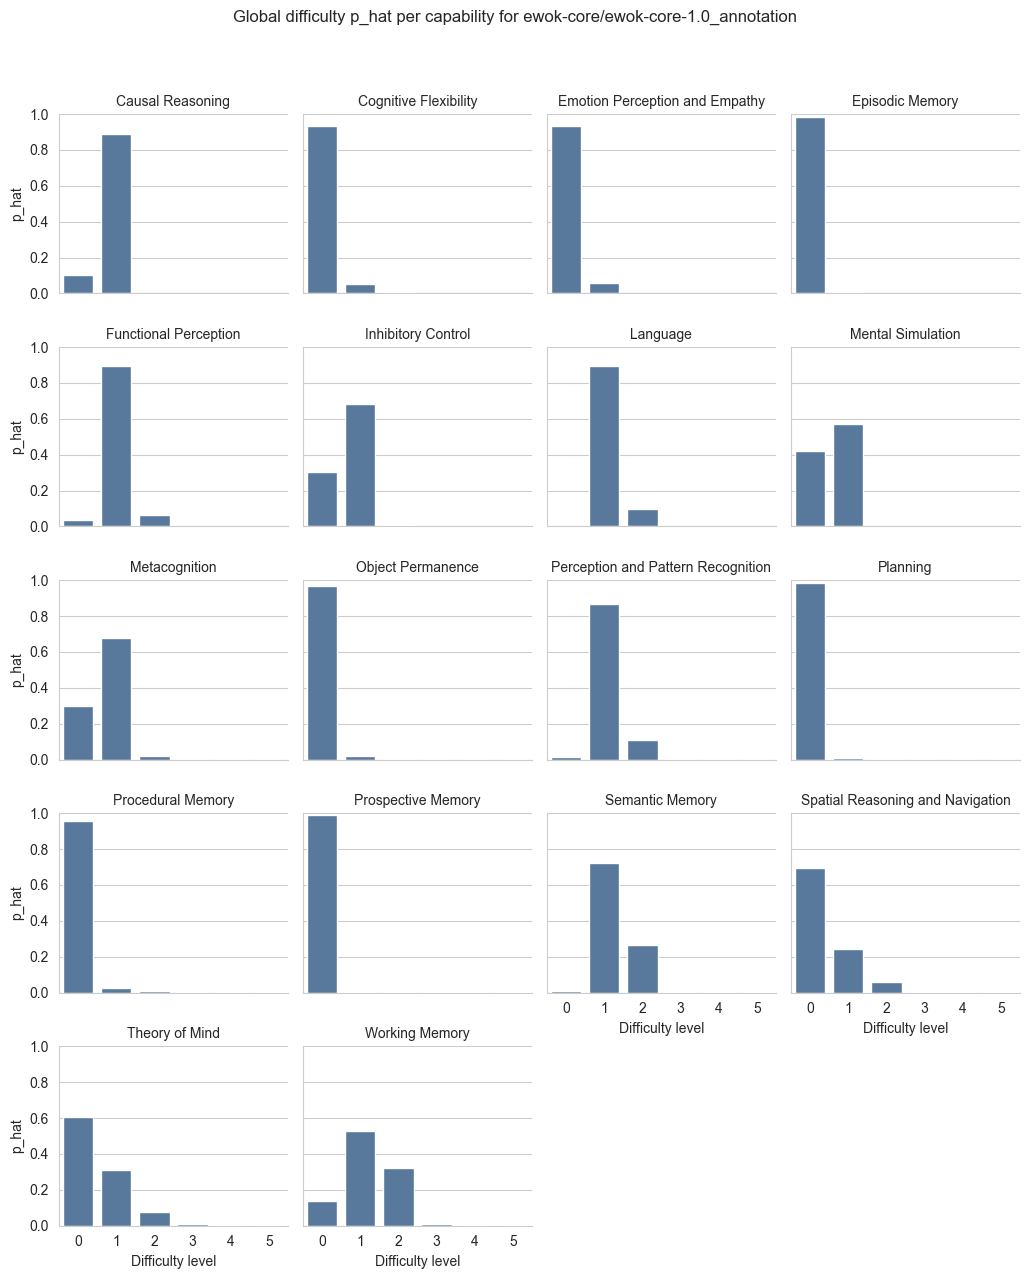

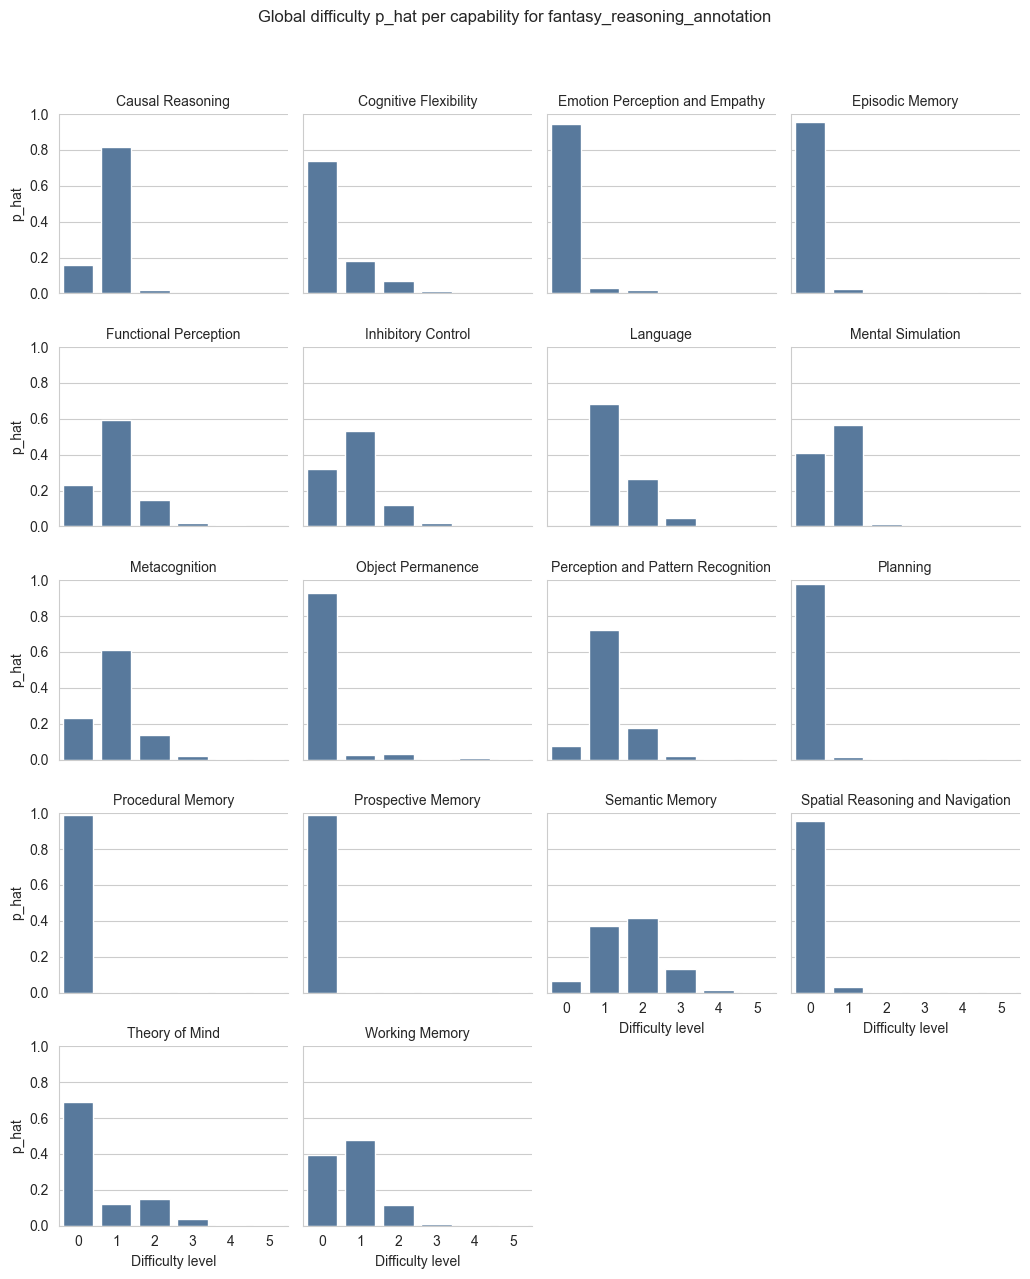

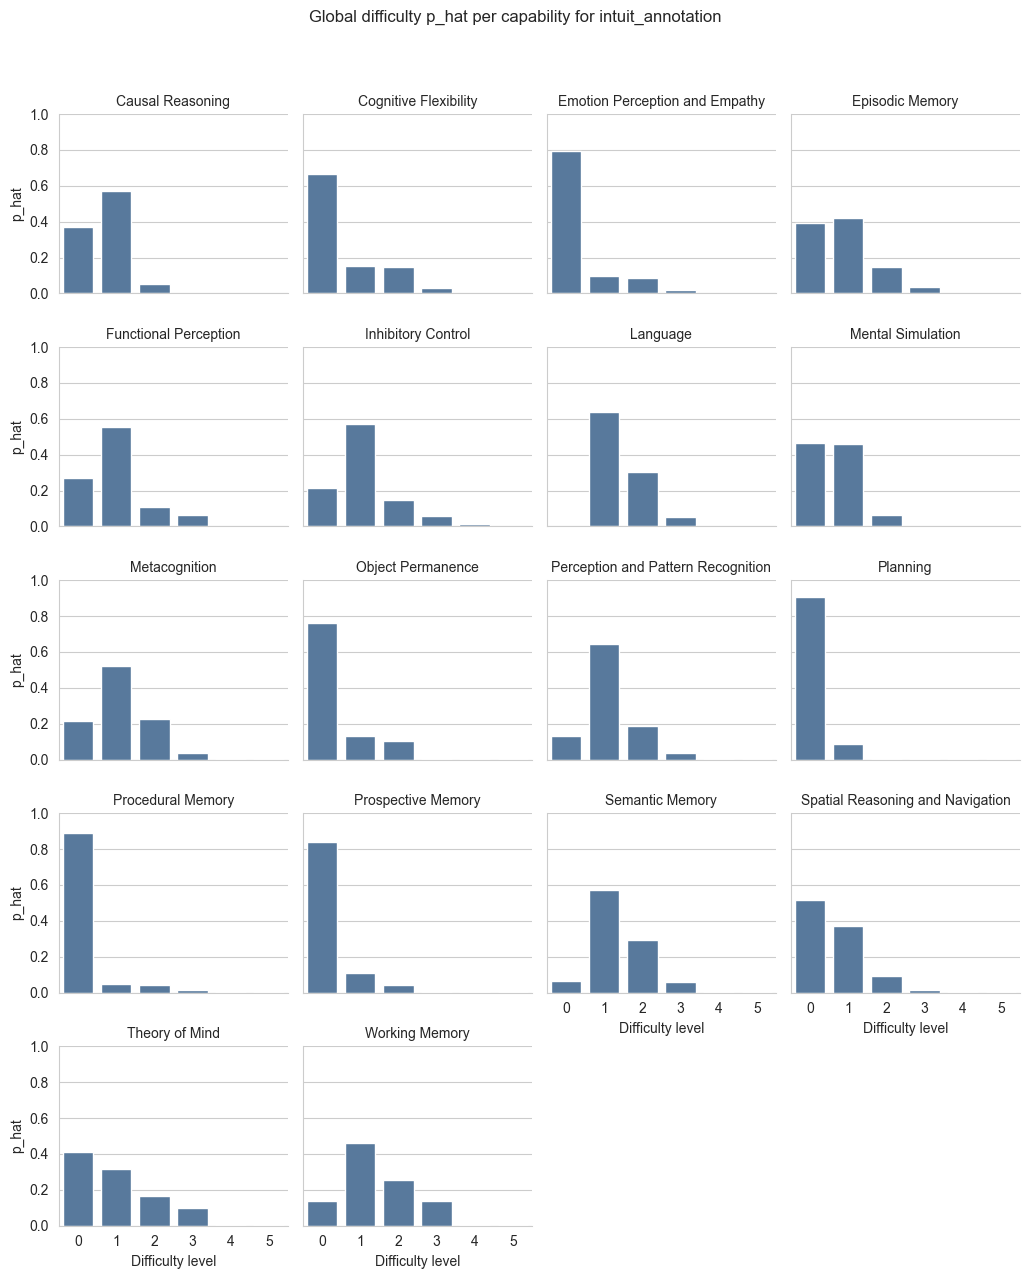

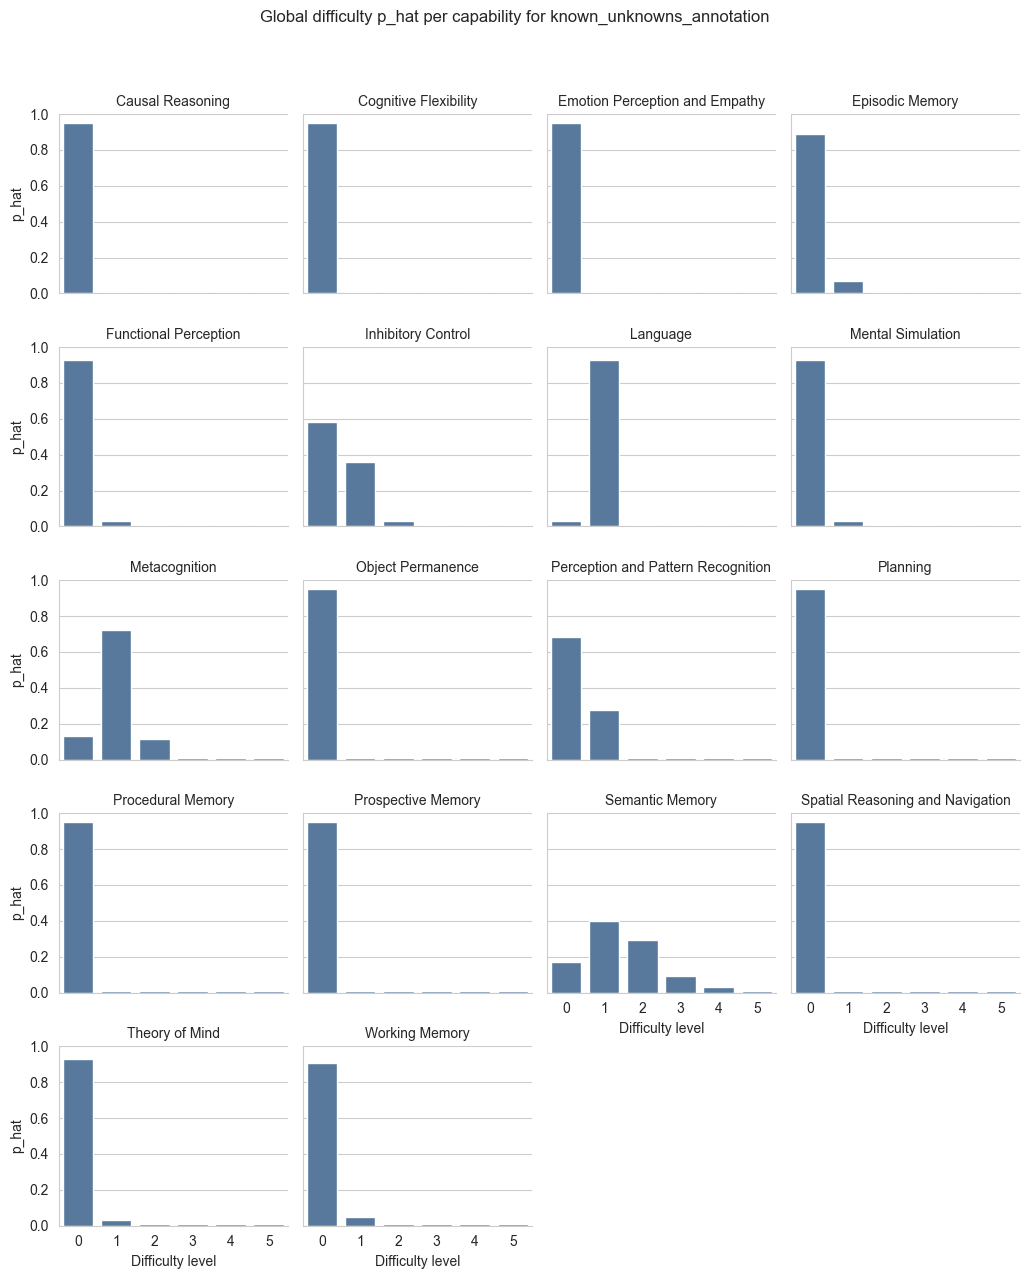

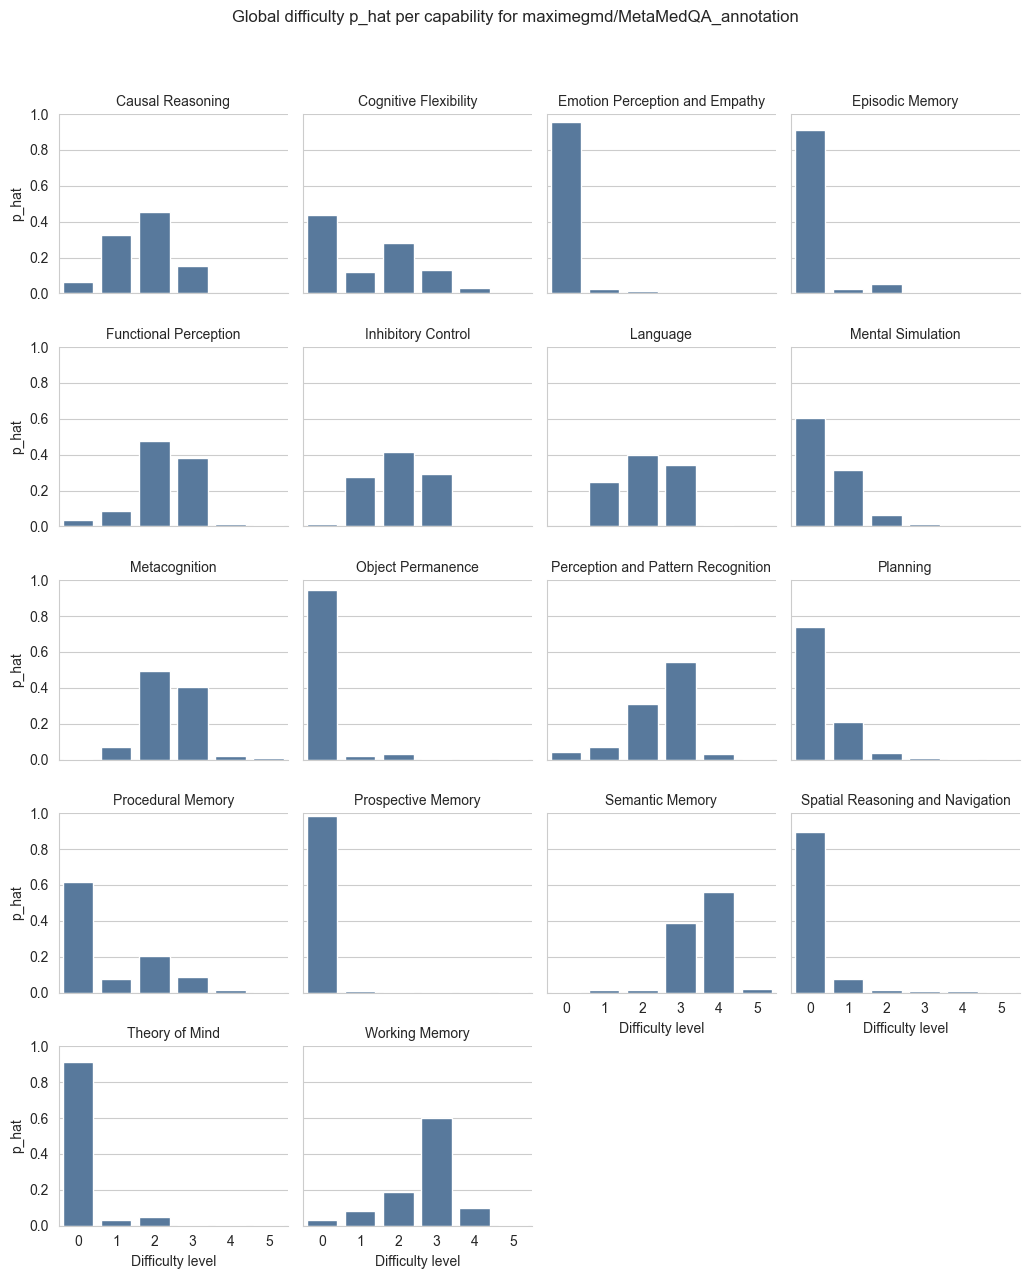

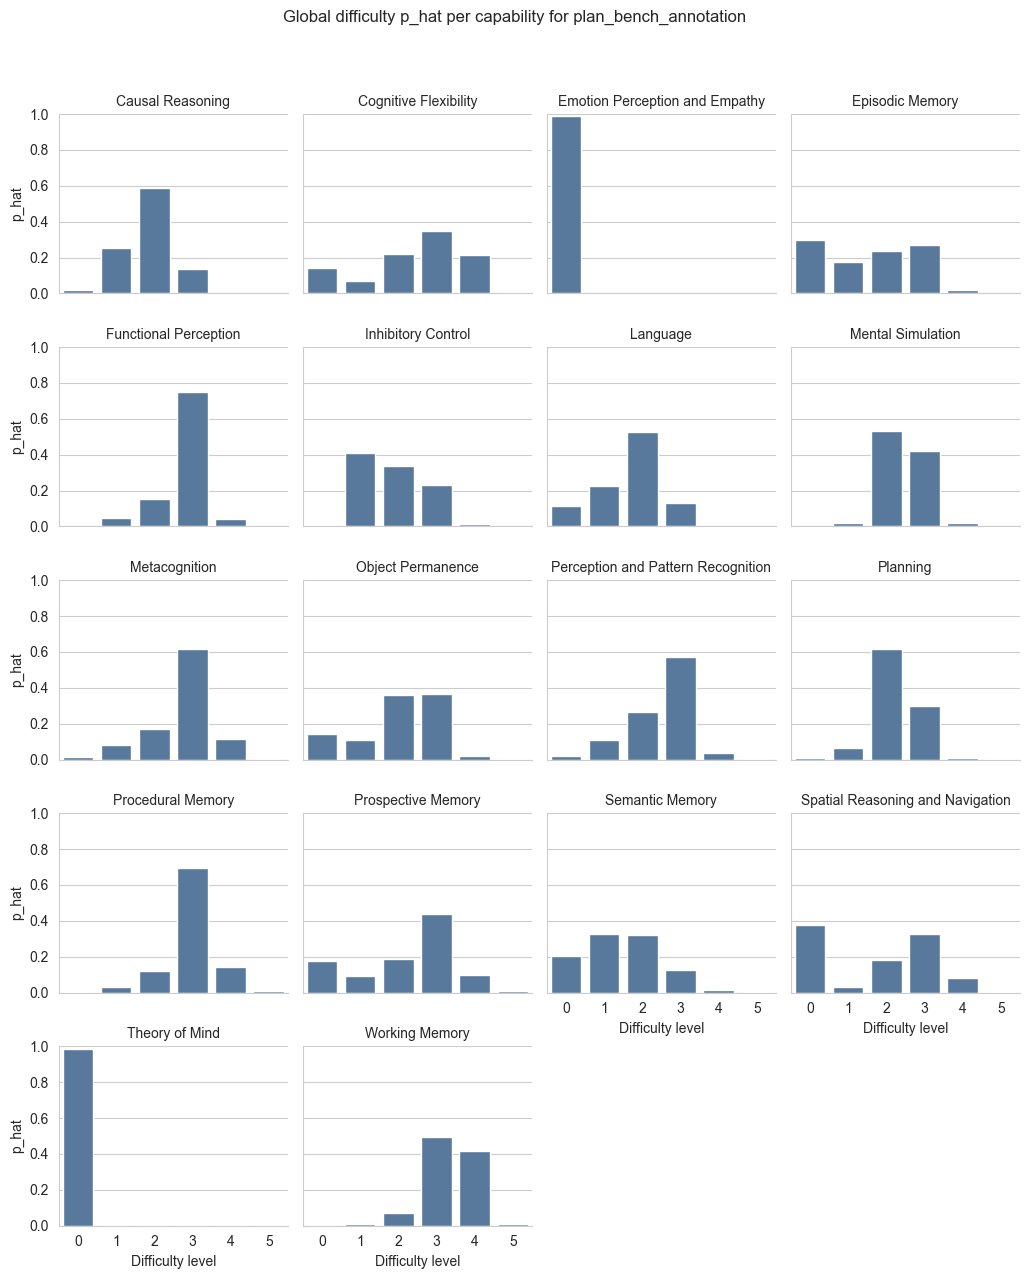

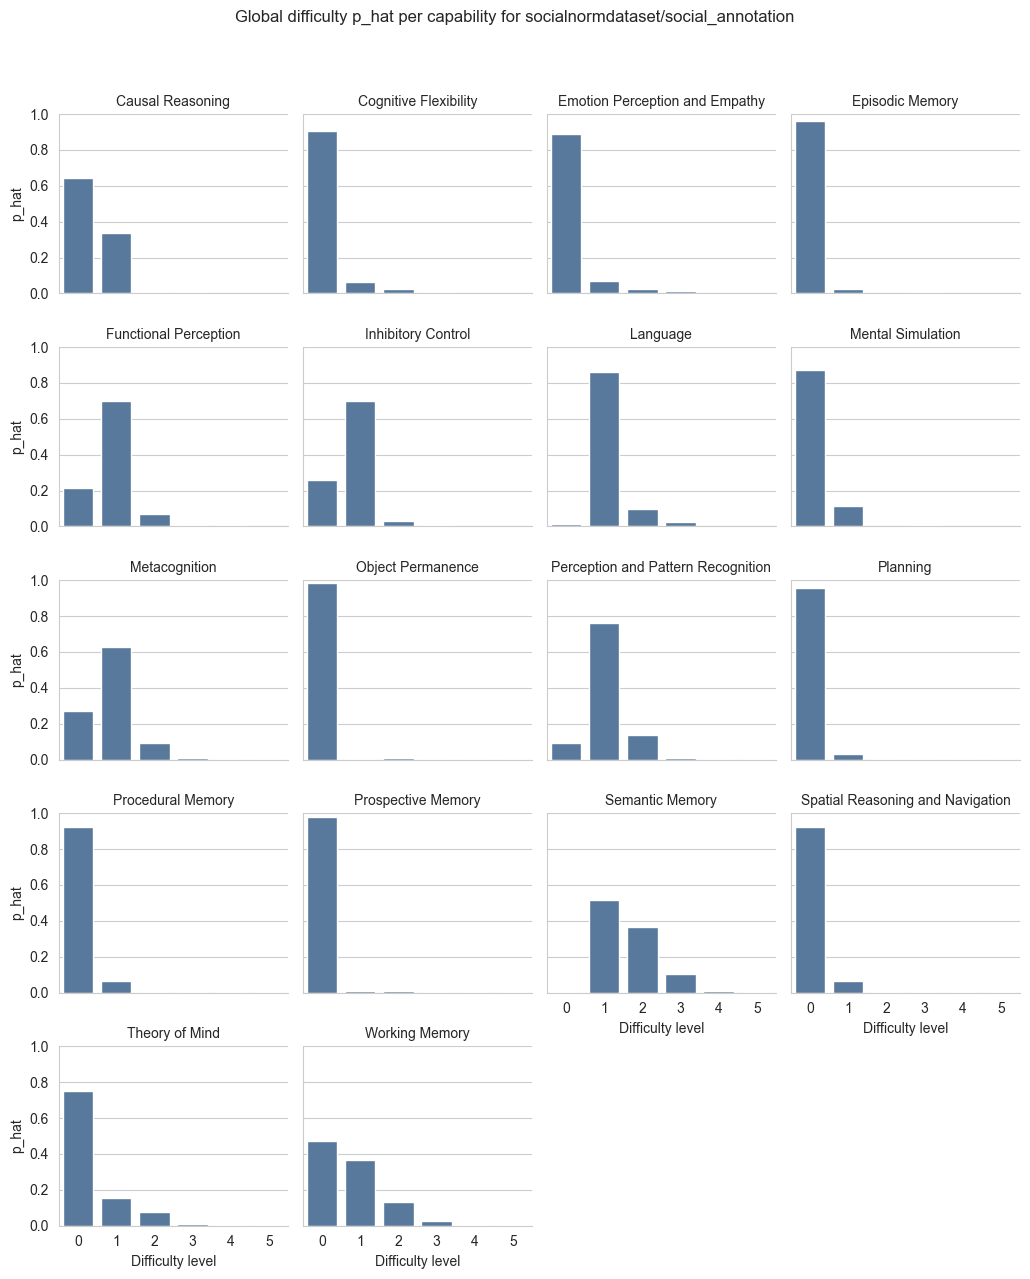

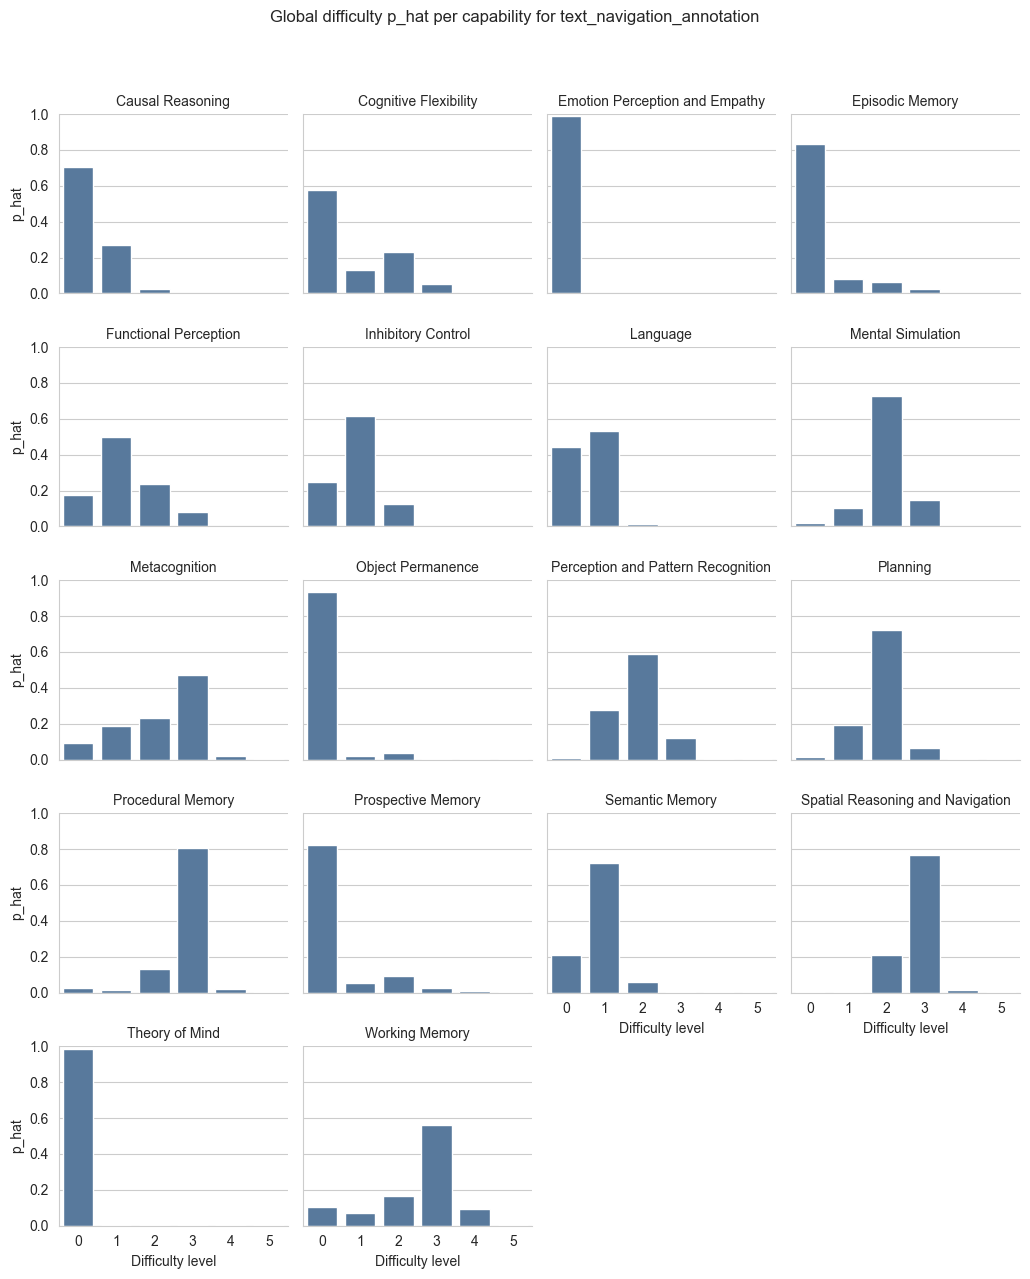

In [957]:
for bi in range(len(datasets)):
    g = sns.FacetGrid(df_diff[df_diff['dataset']==datasets[bi]], col="capability", col_wrap=4, sharex=True, sharey=True, height=2.6)
    g.map_dataframe(sns.barplot, x="difficulty", y="p_hat", color="#4C78A8")
    g.set_titles("{col_name}")
    g.set_xlabels("Difficulty level")
    g.set_ylabels("p_hat")
    for ax in g.axes.flat:
        ax.set_ylim(0, 1)
    plt.subplots_adjust(top=0.9)
    g.figure.suptitle(f"Global difficulty p_hat per capability for {datasets[bi]}")
    plt.show()

In [958]:
def plot_delta_heatmaps_grid(df, datasets, capabilities, SCORE_BINS, vlim=None,
                             cols=3, rows=2, figsize=(12, 7), suptitle=None):
    if vlim is None:
        v = np.percentile(np.abs(df["delta"].values), 99)
        #v = np.max(np.abs(df["delta"].values))
        vlim = float(max(v, 1e-3))

    per_page = cols * rows
    pages = math.ceil(len(datasets) / per_page)

    for p in range(pages):
        start = p * per_page
        end   = min((p+1) * per_page, len(datasets))
        fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
        axes = axes.ravel()

        last_im = None
        for i, ds in enumerate(datasets[start:end]):
            ax = axes[i]
            data = (df.query("dataset == @ds")
                      .pivot(index="capability", columns="difficulty", values="delta")
                      .reindex(index=capabilities, columns=SCORE_BINS))
            last_im = ax.imshow(data.values, aspect="auto", vmin=-vlim, vmax=vlim, cmap="coolwarm")
            ax.set_title(ds, fontsize=10)

            # Shared ticks but show labels only on leftmost column and bottom row
            ax.set_xticks(range(len(SCORE_BINS)))
            ax.set_yticks(range(len(capabilities)))

            is_left_col = (i % cols == 0)
            is_bottom_row = (i // cols == rows - 1)

            if is_bottom_row:
                ax.set_xticklabels(SCORE_BINS, fontsize=8)
            else:
                ax.set_xticklabels([])
            if is_left_col:
                ax.set_yticklabels(capabilities, fontsize=8)
            else:
                ax.set_yticklabels([])

            if is_bottom_row:
                ax.set_xlabel("Difficulty level", fontsize=8)
            else:
                ax.set_xlabel("")
            if is_left_col:
                ax.set_ylabel("capability", fontsize=8)
            else:
                ax.set_ylabel("")

        # hide any unused axes
        for j in range(i+1, len(axes)):
            axes[j].axis("off")

        # place a dedicated colorbar axes (left, bottom, width, height in figure fraction)
        if last_im is not None:
            cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            cbar = fig.colorbar(last_im, cax=cax)
            cbar.set_label("Δ = tilde_p - p_hat")

        if suptitle:
            fig.suptitle(suptitle, y=0.98, fontsize=12)

        # apply tight layout to main grid only
        fig.tight_layout(rect=[0, 0, .86, 1])  # leave space on the right for colorbar
        plt.show()

/var/folders/8p/b1p1gkq92fn61vdqz1rhhgm80000gp/T/ipykernel_81074/2832394425.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .86, 1])  # leave space on the right for colorbar


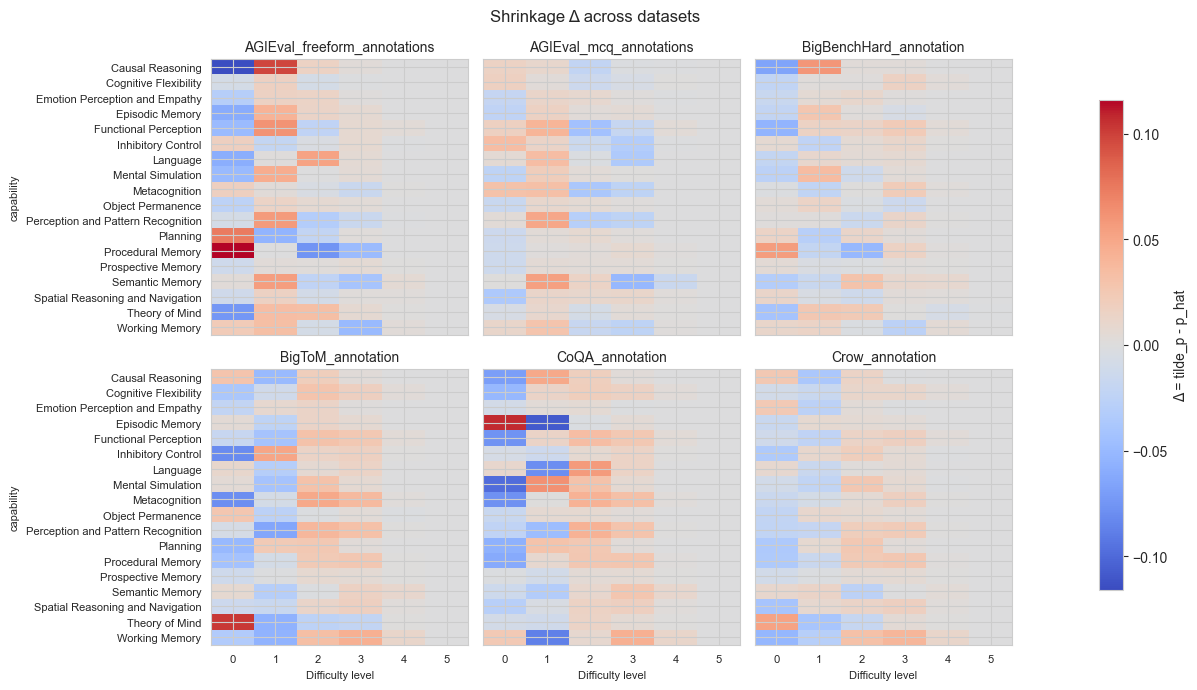

/var/folders/8p/b1p1gkq92fn61vdqz1rhhgm80000gp/T/ipykernel_81074/2832394425.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .86, 1])  # leave space on the right for colorbar


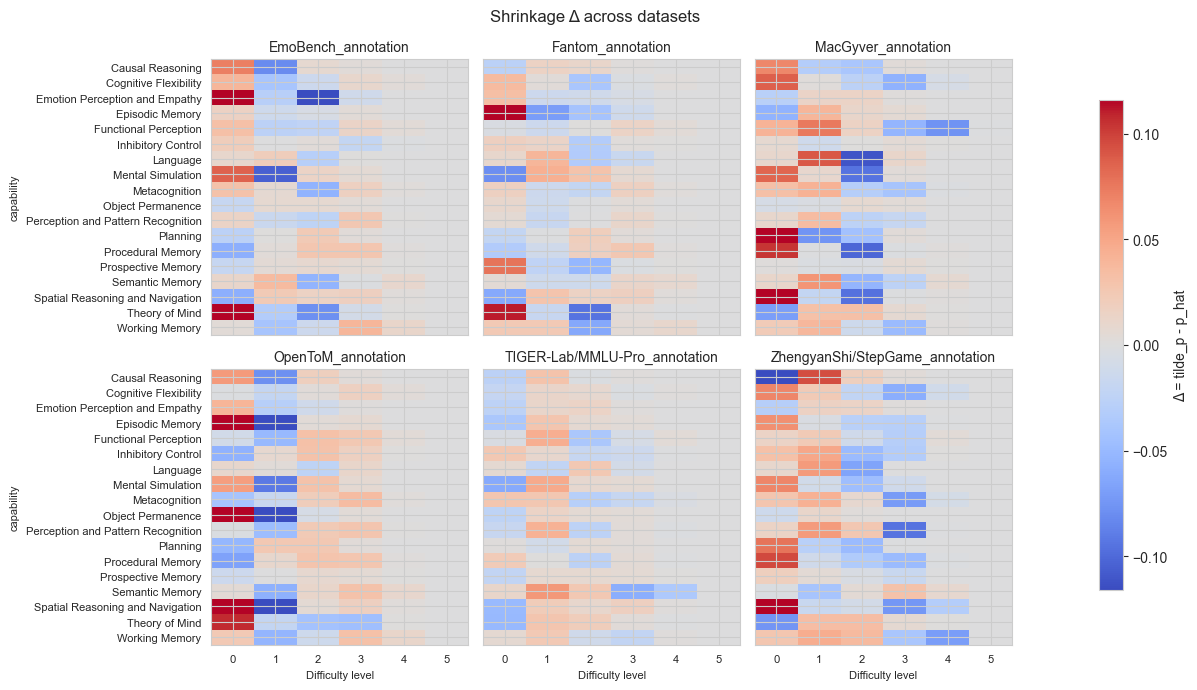

/var/folders/8p/b1p1gkq92fn61vdqz1rhhgm80000gp/T/ipykernel_81074/2832394425.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .86, 1])  # leave space on the right for colorbar


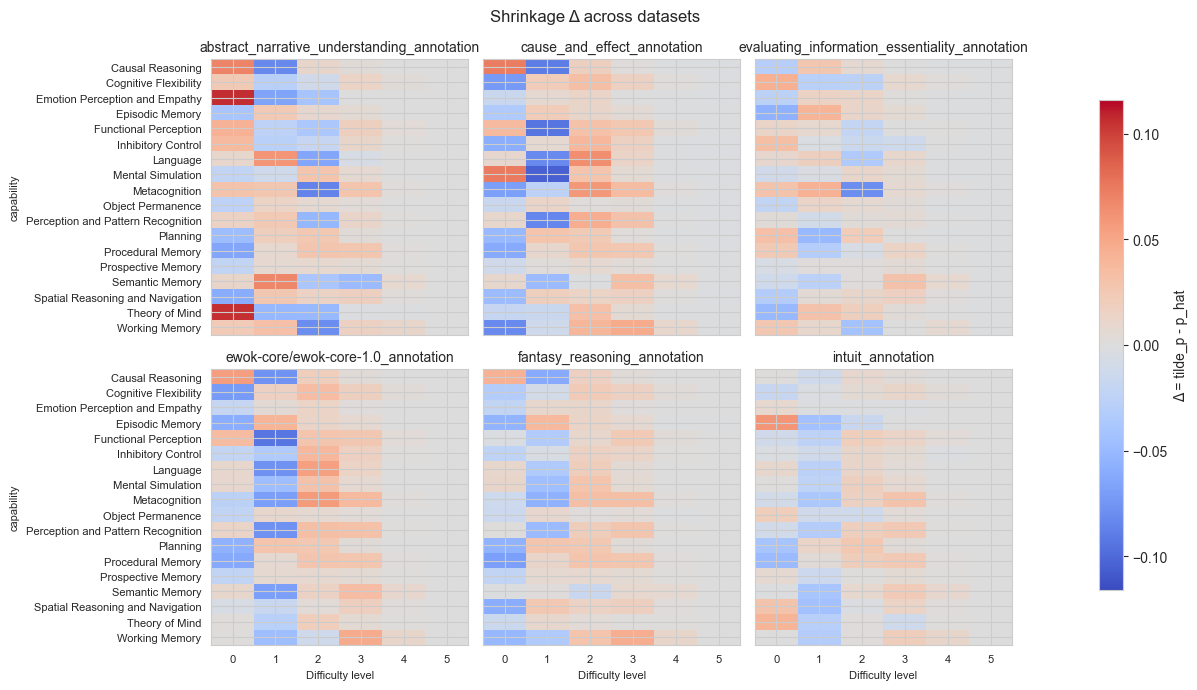

/var/folders/8p/b1p1gkq92fn61vdqz1rhhgm80000gp/T/ipykernel_81074/2832394425.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .86, 1])  # leave space on the right for colorbar


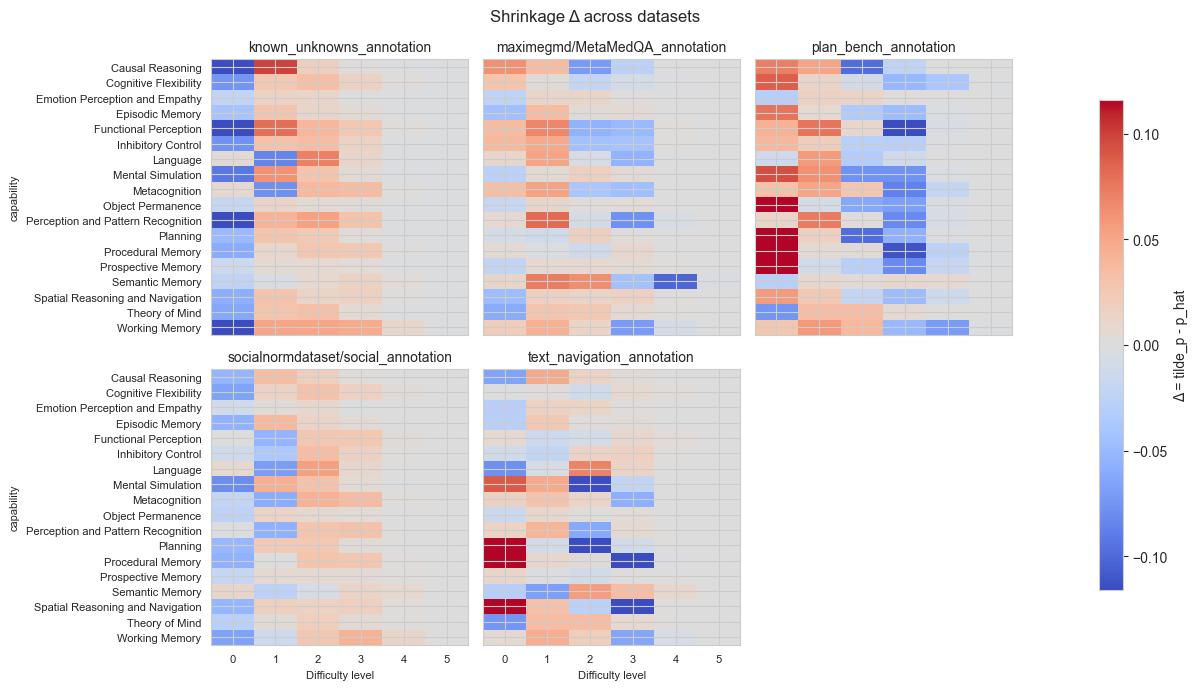

In [959]:
plot_delta_heatmaps_grid(
    df_diff, datasets, capabilities, SCORE_BINS,
    vlim=None, cols=3, rows=2, suptitle="Shrinkage Δ across datasets"
)

# Item dataset capacity

## Number of items already annotated per dataset

In [960]:
items_per_dataset

dataset name
AGIEval_freeform_annotations                      200
AGIEval_mcq_annotations                           200
BigBenchHard_annotation                           200
BigToM_annotation                                 200
CoQA_annotation                                   200
Crow_annotation                                   200
EmoBench_annotation                               200
Fantom_annotation                                 200
MacGyver_annotation                               200
OpenToM_annotation                                200
TIGER-Lab/MMLU-Pro_annotation                     200
ZhengyanShi/StepGame_annotation                   200
abstract_narrative_understanding_annotation       200
cause_and_effect_annotation                        51
evaluating_information_essentiality_annotation     68
ewok-core/ewok-core-1.0_annotation                200
fantasy_reasoning_annotation                      200
intuit_annotation                                 200
known_unknowns_

## Simulate max totals per dataset

In [961]:
datasets

['AGIEval_freeform_annotations',
 'AGIEval_mcq_annotations',
 'BigBenchHard_annotation',
 'BigToM_annotation',
 'CoQA_annotation',
 'Crow_annotation',
 'EmoBench_annotation',
 'Fantom_annotation',
 'MacGyver_annotation',
 'OpenToM_annotation',
 'TIGER-Lab/MMLU-Pro_annotation',
 'ZhengyanShi/StepGame_annotation',
 'abstract_narrative_understanding_annotation',
 'cause_and_effect_annotation',
 'evaluating_information_essentiality_annotation',
 'ewok-core/ewok-core-1.0_annotation',
 'fantasy_reasoning_annotation',
 'intuit_annotation',
 'known_unknowns_annotation',
 'maximegmd/MetaMedQA_annotation',
 'plan_bench_annotation',
 'socialnormdataset/social_annotation',
 'text_navigation_annotation']

In [962]:
max_num_items_dict = {
    'AGIEval_freeform_annotations':1118,
     'AGIEval_mcq_annotations':6154,
     'BigBenchHard_annotation':6511,
     'BigToM_annotation':5000,
     'CoQA_annotation':10930,
     'Crow_annotation':12341,
     'EmoBench_annotation':1200,
     'Fantom_annotation':4150,
     'MacGyver_annotation':1683,
     'OpenToM_annotation':13708,
     'TIGER-Lab/MMLU-Pro_annotation':12032,
     'ZhengyanShi/StepGame_annotation':100000,
     'abstract_narrative_understanding_annotation':1000,
     'cause_and_effect_annotation':51,
     'evaluating_information_essentiality_annotation':68,
     'ewok-core/ewok-core-1.0_annotation':4374,
     'fantasy_reasoning_annotation':201,
     'intuit_annotation':5760,
     'known_unknowns_annotation':46,
     'maximegmd/MetaMedQA_annotation':1373,
     'plan_bench_annotation':15469,
     'socialnormdataset/social_annotation':12383,
     'text_navigation_annotation':100000,
    'llm_babybench_predict_annotation': 8000,
    'llm_babybench_plan_annotation': 8000,
    'llm_babybench_decompose_annotation': 8000,
}

In [963]:
max_num_items_dict

{'AGIEval_freeform_annotations': 1118,
 'AGIEval_mcq_annotations': 6154,
 'BigBenchHard_annotation': 6511,
 'BigToM_annotation': 5000,
 'CoQA_annotation': 10930,
 'Crow_annotation': 12341,
 'EmoBench_annotation': 1200,
 'Fantom_annotation': 4150,
 'MacGyver_annotation': 1683,
 'OpenToM_annotation': 13708,
 'TIGER-Lab/MMLU-Pro_annotation': 12032,
 'ZhengyanShi/StepGame_annotation': 100000,
 'abstract_narrative_understanding_annotation': 1000,
 'cause_and_effect_annotation': 51,
 'evaluating_information_essentiality_annotation': 68,
 'ewok-core/ewok-core-1.0_annotation': 4374,
 'fantasy_reasoning_annotation': 201,
 'intuit_annotation': 5760,
 'known_unknowns_annotation': 46,
 'maximegmd/MetaMedQA_annotation': 1373,
 'plan_bench_annotation': 15469,
 'socialnormdataset/social_annotation': 12383,
 'text_navigation_annotation': 100000,
 'llm_babybench_predict_annotation': 8000,
 'llm_babybench_plan_annotation': 8000,
 'llm_babybench_decompose_annotation': 8000}

No dataset can get more than 10% of total items allocated (i.e. 1800 + 200 = 2000)

In [964]:
max_number_items = pd.Series(
    [max_num_items_dict.get(b, 0) for b in datasets],
    index=datasets,
    dtype=int
)

# No dataset can get more than 10% of total items allocated (i.e. 2000)
max_number_items = np.minimum(max_number_items, 2000)

max_number_items

AGIEval_freeform_annotations                      1118
AGIEval_mcq_annotations                           2000
BigBenchHard_annotation                           2000
BigToM_annotation                                 2000
CoQA_annotation                                   2000
Crow_annotation                                   2000
EmoBench_annotation                               1200
Fantom_annotation                                 2000
MacGyver_annotation                               1683
OpenToM_annotation                                2000
TIGER-Lab/MMLU-Pro_annotation                     2000
ZhengyanShi/StepGame_annotation                   2000
abstract_narrative_understanding_annotation       1000
cause_and_effect_annotation                         51
evaluating_information_essentiality_annotation      68
ewok-core/ewok-core-1.0_annotation                2000
fantasy_reasoning_annotation                       201
intuit_annotation                                 2000
known_unkn

In [965]:
# Compute remaining capacity
cap_items = (max_number_items - items_per_dataset).clip(lower=0)
cap_items

AGIEval_freeform_annotations                       918
AGIEval_mcq_annotations                           1800
BigBenchHard_annotation                           1800
BigToM_annotation                                 1800
CoQA_annotation                                   1800
Crow_annotation                                   1800
EmoBench_annotation                               1000
Fantom_annotation                                 1800
MacGyver_annotation                               1483
OpenToM_annotation                                1800
TIGER-Lab/MMLU-Pro_annotation                     1800
ZhengyanShi/StepGame_annotation                   1800
abstract_narrative_understanding_annotation        800
cause_and_effect_annotation                          0
evaluating_information_essentiality_annotation       0
ewok-core/ewok-core-1.0_annotation                1800
fantasy_reasoning_annotation                         1
intuit_annotation                                 1800
known_unkn

## Total capacity over all datasets

In [966]:
total_cap = float(cap_items.sum())
total_cap

30575.0

In [967]:
remaining_items

15835

# Prepare Inputs for the Allocation Solver

1. **Set Effective Budget**
   - $R$ = desired total number of items
   - $R_{\text{eff}} = \min(R,\ \text{total\_cap})$ = feasible budget considering dataset limits

2. **Assemble Mapping Matrix $P$**
   - Let $C$ = number of capabilities
   - Let $D$ = number of difficulty bins
   - Let $B$ = number of datasets
   - Each column corresponds to a dataset $b$
   - Each row corresponds to a capability–difficulty pair $(c,d)$
   - Entry:
     $$
     P_{((c,d),\,b)} \;=\; \tilde p_{b,c,d}
     $$
     where $\tilde p_{b,c,d}$ is the **shrunk probability** that an item from dataset $b$ falls into capability $c$ and difficulty bin $d$.

   So,
   $$
   P \in \mathbb{R}^{(C\cdot D)\times B}
   $$

    $$P =
    \begin{bmatrix}
    \tilde p_{1,c_1,d_1} & \tilde p_{2,c_1,d_1} & \dots & \tilde p_{B,c_1,d_1} \\
    \tilde p_{1,c_1,d_2} & \tilde p_{2,c_1,d_2} & \dots & \tilde p_{B,c_1,d_2} \\
    \vdots & \vdots & & \vdots \\
    \tilde p_{1,c_C,d_D} & \tilde p_{2,c_C,d_D} & \dots & \tilde p_{B,c_C,d_D}
    \end{bmatrix}
    $$


3. **Build Target Assignment Vector $G_{\text{vec}}$**
   - Flatten the table $G_{c,d}$ of desired assignments (or current assignment gaps) into a vector:
     $$
     G_{\text{vec}}
       = [\,G_{c_1,d_1},\ G_{c_1,d_2},\ \dots,\ G_{c_C,d_D}\,]^\top
     $$

4. **Rescale the Target Vector**
   - Adjust $G_{\text{vec}}$ so that its total mass matches the feasible total budget:
     $$
     \sum_{i} G_{\text{vec},\,i}^{(\text{rescaled})}
       \;=\; C \times R_{\text{eff}}
     $$
   - This preserves the **relative proportions** across bins from the original $G_{\text{vec}}$ but aligns the **total** with the number of assignments achievable with $R_{\text{eff}}$ items.

---

## Notes
- Each column of $P$ represents the expected *distribution of assignments* contributed by one unit (one item) of dataset $b$.
- Multiplying $P$ by an allocation vector $n$ yields the expected assignment counts across all $(c,d)$ bins:
  $$
  Pn \in \mathbb{R}^{C\cdot D}
  $$
- Capacities $(\text{cap}_b)$ and budget $(R_{\text{eff}})$ are enforced in the optimisation step, not in $P$ or $G_{\text{vec}}$.

This setup ensures the optimisation problem is properly defined, with realistic totals and consistent scaling between target assignments and achievable assignments from the available datasets.

In [968]:
R = float(remaining_items)
R_eff = min(R, total_cap)
rows = [(c, d) for c in capabilities for d in SCORE_BINS]
B = len(datasets)

P = np.column_stack([
    np.array([float(tilde_p[b].loc[c, d]) for (c, d) in rows], dtype=float)
    for b in datasets
])

G_vec = np.array([float(G_cd.loc[c, d]) for (c, d) in rows], dtype=float)
print(G_vec.sum())
# Rescale G to match achievable assignments C * R_eff
G_sum = float(G_vec.sum())
target_assignments = float(C * R_eff)
if G_sum > 0 and not np.isclose(G_sum, target_assignments):
    G_vec *= (target_assignments / G_sum)

print(G_vec.sum())

285031.99999999994
285031.99999999994


# Allocation via Constrained Quadratic Fit (SLSQP)

This cell solves the **allocation problem**

$$
\min_{\,0 \le n_b \le \mathrm{cap}_b,\;\sum_b n_b = R_{\mathrm{eff}} }
\;\bigl\|\,G_{\mathrm{vec}} - P\,n\,\bigr\|_2^2
$$

where:
- $n = [n_1,\dots,n_B]^\top$ = **allocation vector**, the number of items to sample from each dataset $b$
- $P$ = mapping from datasets to capability–difficulty bins
- $G_{\text{vec}}$ = target assignment counts across all bins
- Bounds:
    - $0 \le n_b \le \text{cap}_b$, i.e. cannot allocate more items to dataset $b$ than its available stock $\mathrm{cap}_b$.
    - $R_{\text{eff}}$ = feasible total budget of items, don't exceed it

In [971]:
# -------- MAIN SOLVER: SLSQP ONLY -----------------------
R = float(remaining_items)

if total_cap <= 0 or R <= 0:
    alloc_opt = pd.Series(0.0, index=datasets)
else:
    R_eff = min(R, total_cap)

    # 1) Build P ((C*D) x B) from shrunk probabilities tilde_p
    rows = [(c, d) for c in capabilities for d in SCORE_BINS]
    B = len(datasets)
    P = np.column_stack([
        np.array([float(tilde_p[b].loc[c, d]) for (c, d) in rows], dtype=float)
        for b in datasets
    ])

    # 2) Build G as the assignment gap vector (length C*D)
    G_vec = np.array([float(G_cd.loc[c, d]) for (c, d) in rows], dtype=float)

    # Rescale G to match achievable assignments C * R_eff
    G_sum = float(G_vec.sum())
    target_assignments = float(C * R_eff)
    if G_sum > 0 and not np.isclose(G_sum, target_assignments):
        G_vec *= (target_assignments / G_sum)

    print('P and G are finite:', np.isfinite(P).all() and np.isfinite(G_vec).all())

    # 3) Quadratic pieces for 0.5||G - Pn||^2 (up to a constant)
    #rho = 1e-8
    Q = P.T @ P #+ rho*np.eye(B)
    c_vec = - P.T @ G_vec
    def obj(n):  return 0.5*n @ Q @ n + c_vec @ n
    def grad(n): return Q @ n + c_vec

    # Bounds: 0 <= n_b <= cap_b
    bounds = [(0.0, float(cap_items.iloc[j])) for j in range(B)]

    # Simplex constraint: sum(n_b) = R_eff
    cons = [{'type': 'eq',
             'fun': lambda n: np.sum(n) - R_eff,
             'jac': lambda n: np.ones_like(n)}]

    # Feasible initialiser on capped simplex
    def project_capped_simplex(x, caps, R_eff, tol=1e-12):
        """
        Project x onto { n : 0 <= n <= caps, sum(n) = min(R_eff, sum(caps)) }.
        Water-filling style projection.
        """
        x    = np.asarray(x, float)
        caps = np.asarray(caps, float)
        R_eff = float(min(R_eff, caps.sum()))
        B = x.size

        # start by clipping to the box
        n = np.minimum(np.maximum(x, 0.0), caps)
        err = R_eff - n.sum()
        if abs(err) <= tol:
            return n

        free = np.ones(B, dtype=bool)
        if err > 0:   # need to add mass
            free &= (n < caps - tol)
        else:         # need to remove mass
            free &= (n > tol)

        remaining = R_eff - n.sum()
        for _ in range(B + 2):
            k = free.sum()
            if k == 0:
                break
            share = remaining / k
            trial = n.copy()
            trial[free] = n[free] + share
            trial = np.minimum(np.maximum(trial, 0.0), caps)
            n = trial
            remaining = R_eff - n.sum()
            if abs(remaining) <= tol:
                return n
            hit_hi = (n >= caps - tol) & free
            hit_lo = (n <= tol) & free
            free[hit_hi | hit_lo] = False

        # tiny final correction if needed
        err = R_eff - n.sum()
        if abs(err) > 10*tol:
            idx = np.where((n > tol) & (n < caps - tol))[0]
            if idx.size:
                n[idx] += err / idx.size
                n = np.minimum(np.maximum(n, 0.0), caps)
        return n

    caps_vec = cap_items.values.astype(float)
    R_eff    = float(min(R_eff, caps_vec.sum()))
    x0       = np.full_like(caps_vec, R_eff / max(len(caps_vec), 1))
    n0       = project_capped_simplex(x0, caps_vec, R_eff)
    print("sum(n0) after init:", n0.sum(), "should equal R_eff:", R_eff)

    res = minimize(obj, n0, jac=grad, bounds=bounds, constraints=cons,
               method='SLSQP')

    print("res.success:", res.success, "message:", res.message)
    print("R_eff:", R_eff, "sum caps:", float(cap_items.sum()))
    print("rank(P):", np.linalg.matrix_rank(P), "B:", P.shape[1])

    if res.success:
        # Ensure all allocations stay within [0, capacity] by clipping tiny numerical violations from the solver
        n_items = np.clip(res.x, 0.0, caps_vec)
        alloc_opt = pd.Series(n_items, index=datasets)
    else:
        # leave None; run the PGD fallback cell next if you want
        alloc_opt = None

P and G are finite: True
sum(n0) after init: 15835.0 should equal R_eff: 15835.0
res.success: True message: Optimization terminated successfully
R_eff: 15835.0 sum caps: 30575.0
rank(P): 23 B: 23


## Diagnostics

In [972]:
# ---- Sanity / feasibility
n = np.clip(res.x, 0.0, cap_items.values)  # should already be within [0, caps]
print("sum(n):", n.sum(), "target R_eff:", R_eff)
print(f"any <0? {np.any(n < -1e-9)}   any >cap? {np.any(n - cap_items.values > 1e-9)}")

# how many hit caps?
at_cap = np.isclose(n, cap_items.values, atol=1e-9)
at_zero = np.isclose(n, 0.0, atol=1e-9)
print(f"\ndatasets at cap: {at_cap.sum()} / {len(n)}   datasets at 0: {at_zero.sum()} / {len(n)}")

# biggest under/over-filled bins
rows = [(c, d) for c in capabilities for d in SCORE_BINS]
ix_under = np.argsort(-r)[:10]           # largest positive residuals (underfill)
ix_over  = np.argsort(r)[:10]            # most negative (overfill)
print("\nTop underfill bins:", [(rows[i], r[i]) for i in ix_under])
print("\nTop overfill bins :", [(rows[i], r[i]) for i in ix_over])

sum(n): 15834.99999937108 target R_eff: 15835.0
any <0? False   any >cap? False

datasets at cap: 9 / 23   datasets at 0: 3 / 23

Top underfill bins: [(('Causal Reasoning', 4), np.float64(923.4871629307644)), (('Episodic Memory', 5), np.float64(923.4871629307642)), (('Emotion Perception and Empathy', 4), np.float64(923.4871629307642)), (('Language', 5), np.float64(922.0080362511804)), (('Perception and Pattern Recognition', 5), np.float64(922.0080362511804)), (('Causal Reasoning', 5), np.float64(922.0080362511803)), (('Object Permanence', 5), np.float64(922.0080362511803)), (('Mental Simulation', 5), np.float64(922.0080362511803)), (('Spatial Reasoning and Navigation', 5), np.float64(922.0080362511803)), (('Inhibitory Control', 5), np.float64(922.0080362511802))]

Top overfill bins : [(('Emotion Perception and Empathy', 0), np.float64(-3310.138155840814)), (('Prospective Memory', 0), np.float64(-2690.7307654890574)), (('Object Permanence', 0), np.float64(-2408.4627374813335)), (('Langu

### How large the residual is compared to the target itself

In [973]:
# ---- Objective & relative L2 error
r = G_vec - P @ n
objective_val = obj(n)
rel_L2 = float(np.linalg.norm(r) / (np.linalg.norm(G_vec) + 1e-12))
print(f"Objective = {objective_val:.2f}")
print(f"Relative L2 fit = {rel_L2:.3f}  ({rel_L2*100:.1f}% of target magnitude)")

Objective = -566292841.30
Relative L2 fit = 0.288  (28.8% of target magnitude)


### Residuals

In [974]:
# ---- Top residual bins (magnitude)
rows = [(c, d) for c in capabilities for d in SCORE_BINS]
idx = np.argsort(-np.abs(r))[:15]
print("Top |residual| bins:")
for i in idx:
    c, d = rows[i]
    print(f"  {str((c,d)):40s}  resid = {r[i]: .3f}  ({'underfill' if r[i]>0 else 'overfill'})")

# ---- Aggregate residuals per capability (sum across difficulty)
import numpy as np
cap_to_inds = {c: [i for i,(cc,_) in enumerate(rows) if cc==c] for c in capabilities}
cap_resid = {c: float(r[cap_to_inds[c]].sum()) for c in capabilities}
cap_sorted = sorted(cap_resid.items(), key=lambda x: -abs(x[1]))[:10]
print("\nLargest per-capability residual totals:")
for c,val in cap_sorted:
    print(f"  {c:40s}  total resid = {val: .1f}")

Top |residual| bins:
  ('Emotion Perception and Empathy', 0)     resid = -3515.989  (overfill)
  ('Prospective Memory', 0)                 resid = -2901.904  (overfill)
  ('Object Permanence', 0)                  resid = -2615.643  (overfill)
  ('Language', 2)                           resid = -2087.454  (overfill)
  ('Theory of Mind', 0)                     resid = -2073.268  (overfill)
  ('Planning', 0)                           resid = -1668.373  (overfill)
  ('Semantic Memory', 1)                    resid = -1558.755  (overfill)
  ('Causal Reasoning', 1)                   resid = -1524.913  (overfill)
  ('Inhibitory Control', 1)                 resid = -1456.274  (overfill)
  ('Procedural Memory', 0)                  resid = -1346.624  (overfill)
  ('Working Memory', 3)                     resid = -1216.215  (overfill)
  ('Spatial Reasoning and Navigation', 0)   resid = -1162.176  (overfill)
  ('Episodic Memory', 1)                    resid = -1158.065  (overfill)
  ('Mental Simula

### Comparisons to baselines

In [975]:
# --- Helpers (same objective the solver used) ---
def objective(n):
    r = G_vec - P @ n
    return 0.5 * float(r @ r)

def rel_L2(n):
    r = G_vec - P @ n
    return float(np.linalg.norm(r) / (np.linalg.norm(G_vec) + 1e-12))

# --- Guard: need a solved allocation ---
if alloc_opt is None:
    raise RuntimeError("Optimization did not succeed; no alloc_opt to compare.")

n_opt = alloc_opt.values.astype(float)

# --- Baseline 1: uniform over datasets, respecting caps & sum ---
n_uniform = np.minimum(R_eff / B, cap_items.values.astype(float))
n_uniform = project_capped_simplex(n_uniform, cap_items.values, R_eff)  # enforce sum & caps

# --- Baseline 2: cap-proportional (distribute budget by available capacity) ---
cap = cap_items.values.astype(float)
w = cap / max(cap.sum(), 1e-12)
n_capprop = project_capped_simplex(w * R_eff, cap, R_eff)

# --- Baseline 3: random feasible (average a few to gauge variance) ---
rng = np.random.default_rng(0)
rand_trials = []
for _ in range(10):
    weights = rng.random(B)
    weights /= weights.sum()
    n_rand = project_capped_simplex(weights * R_eff, cap, R_eff)
    rand_trials.append(n_rand)
n_rand_mean = np.mean([objective(x) for x in rand_trials])
n_rand_std  = np.std([objective(x) for x in rand_trials])

# --- Report: objective and relative L2 ---
obj_opt  = objective(n_opt)
obj_uni  = objective(n_uniform)
obj_cap  = objective(n_capprop)

rel_opt  = rel_L2(n_opt)
rel_uni  = rel_L2(n_uniform)
rel_cap  = rel_L2(n_capprop)

print(f"Objective(opt)        = {obj_opt:,.2f}")
print(f"Objective(uniform)    = {obj_uni:,.2f}   | improvement = {(1 - obj_opt/obj_uni)*100:,.1f}%")
print(f"Objective(cap-prop)   = {obj_cap:,.2f}   | improvement = {(1 - obj_opt/obj_cap)*100:,.1f}%")
print(f"Objective(random, μ±σ)= {n_rand_mean:,.2f} ± {n_rand_std:,.2f} | improvement vs μ = {(1 - obj_opt/n_rand_mean)*100:,.1f}%")

print()
print(f"Rel L2(opt)      = {rel_opt:.3f}")
print(f"Rel L2(uniform)  = {rel_uni:.3f}  | improvement = {(rel_uni-rel_opt)/max(rel_uni,1e-12)*100:.1f}%")
print(f"Rel L2(cap-prop) = {rel_cap:.3f}  | improvement = {(rel_cap-rel_opt)/max(rel_cap,1e-12)*100:.1f}%")

Objective(opt)        = 51,035,615.76
Objective(uniform)    = 76,655,348.20   | improvement = 33.4%
Objective(cap-prop)   = 76,891,259.35   | improvement = 33.6%
Objective(random, μ±σ)= 78,854,118.01 ± 6,036,286.52 | improvement vs μ = 35.3%

Rel L2(opt)      = 0.288
Rel L2(uniform)  = 0.352  | improvement = 18.4%
Rel L2(cap-prop) = 0.353  | improvement = 18.5%


# PGD Solver for Capped-Simplex Allocation

**Goal:** Allocate a fixed budget $R_{\mathrm{eff}}$ across datasets to best match a target assignment profile $G$, while respecting per-dataset capacity limits.

**Procedure:** We minimise the squared gap $\tfrac12\|G - Pn\|_2^2 $ by **Projected Gradient Descent**:
each step moves $n$ downhill along the gradient, then projects back to the **capped simplex**
$
\{\,n\ |\ 0 \le n_b \le \mathrm{cap}_b,\ \sum_b n_b = R_{\mathrm{eff}} \}.
$

---

## Algorithm
1. **Init:** Start with a feasible allocation via water-filling.
2. **Iterate:**
   - Gradient step: $ y = n - \alpha \nabla f(n) $
   - Projection back to capped simplex.
3. **Stop** when updates are small or max iterations reached.

---

## Diagnostics
Tracked each iteration to assess convergence:
- Objective $ 0.5\|G - Pn\|^2 $
- Step change ‖nₖ₊₁ − nₖ‖₁
- Budget residual $ \sum n - R_{\mathrm{eff}} $
- Max capacity violation
- Count of datasets at capacity
- Gradient norm

---

## Output
Final allocation `n`:
- Satisfies budget and capacity constraints
- Minimizes mismatch between model-implied assignments \(Pn\) and target \(G\)
- Ready for performance evaluation and baseline comparison.

In [976]:
# -------- FALLBACK: PROJECTED GRADIENT DESCENT -----------
if True:# alloc_opt is None:
    # Reuse P, G_vec, R_eff, caps_vec defined in the previous cell

    def project_capped_simplex(x, caps, R_eff, tol=1e-12):
        """
        Project x onto { n : 0 <= n <= caps, sum(n) = min(R_eff, sum(caps)) }.
        Implements a water-filling style projection with box constraints.
        """
        x    = np.asarray(x, float)
        caps = np.asarray(caps, float)
        R_eff = float(min(R_eff, caps.sum()))
        B = x.size

        n = np.minimum(np.maximum(x, 0.0), caps)
        err = R_eff - n.sum()
        if abs(err) <= tol:
            return n

        free = np.ones(B, dtype=bool)
        if err > 0:   # need to add mass
            free &= (n < caps - tol)
        else:         # need to remove mass
            free &= (n > tol)

        remaining = R_eff - n.sum()
        for _ in range(B + 2):
            k = free.sum()
            if k == 0:
                break
            share = remaining / k
            trial = n.copy()
            trial[free] = n[free] + share
            trial = np.minimum(np.maximum(trial, 0.0), caps)
            n = trial
            remaining = R_eff - n.sum()
            if abs(remaining) <= tol:
                return n
            hit_hi = (n >= caps - tol) & free
            hit_lo = (n <= tol) & free
            stuck = hit_hi | hit_lo
            if not stuck.any():
                n[free] += remaining / k
                n = np.minimum(np.maximum(n, 0.0), caps)
                if abs(R_eff - n.sum()) <= tol:
                    return n
            free[stuck] = False

        n = np.minimum(np.maximum(n, 0.0), caps)
        # final tiny correction if still off
        err = R_eff - n.sum()
        if abs(err) > 10*tol:
            idx = np.where((n > tol) & (n < caps - tol))[0]
            if idx.size > 0:
                n[idx] += err / idx.size
                n = np.minimum(np.maximum(n, 0.0), caps)
        return n

    def project_box_simplex(y, caps, R_eff):
        y = np.minimum(np.maximum(y, 0.0), caps)
        return project_capped_simplex(y, caps, R_eff)

    # Q and gradient pieces (add tiny ridge for stability)
    ridge = 1e-10
    Q     = P.T @ P + ridge * np.eye(P.shape[1])
    PTG   = P.T @ G_vec

    def grad_obj(n):
        # gradient of 0.5 * ||G - Pn||^2 = Q n - P^T G
        return Q @ n - PTG

    # feasible init (same as SLSQP cell)
    def capped_simplex_init(caps, R_eff):
        caps = np.asarray(caps, float)
        R_eff = float(min(R_eff, caps.sum()))
        n = np.zeros_like(caps)
        free = np.ones_like(caps, dtype=bool)
        remaining = R_eff
        for _ in range(len(caps) + 2):
            k = free.sum()
            if k == 0:
                break
            share = remaining / k
            n[free] = np.minimum(n[free] + share, caps[free])
            hit = (n >= caps - 1e-12) & free
            remaining = R_eff - n.sum()
            if remaining <= 1e-12:
                break
            free[hit] = False
        return n

    n = capped_simplex_init(caps_vec, R_eff)

    # --- diagnostics container ---
    hist = {
        "iter": [],          # iteration index
        "obj": [],           # 0.5||G - Pn||² objective
        "l1_step": [],       # ||n_new - n||₁  (size of step)
        "grad_norm": [],     # ||grad f(n)||₂
        "sum_resid": [],     # sum(n) - R_eff  (should be ~0)
        "max_cap_over": [],  # any violation of upper bound
        "n_at_cap": [],      # #datasets exactly at cap
    }
    # PGD loop
    max_iter = 40000
    alpha    = 1e-3    # step size;
    tol      = 1e-6

    def objective(n):
        r = G_vec - P @ n
        return 0.5 * float(r @ r)

    for it in range(max_iter):
        # gradient step
        g    = grad_obj(n)
        y    = n - alpha * g

        # project back onto feasible box+simplex
        n_new= project_box_simplex(y, caps_vec, R_eff)
        # ---- record diagnostics ----
        hist["iter"].append(it)
        hist["obj"].append(objective(n))
        hist["l1_step"].append(float(np.linalg.norm(n_new - n, 1)))
        hist["grad_norm"].append(float(np.linalg.norm(g, 2)))
        hist["sum_resid"].append(float(n_new.sum() - R_eff))
        hist["max_cap_over"].append(float(np.max(n_new - caps_vec)))
        hist["n_at_cap"].append(int(np.sum(np.isclose(n_new, caps_vec, atol=1e-10))))

        # ---- stopping test ----
        if np.linalg.norm(n_new - n, ord=1) < tol:
            n = n_new
            break
        n = n_new

    alloc_pgd = pd.Series(n, index=datasets)

In [977]:
alloc_pgd

AGIEval_freeform_annotations                      719.143203
AGIEval_mcq_annotations                            20.143104
BigBenchHard_annotation                          1048.479235
BigToM_annotation                                 468.807564
CoQA_annotation                                    20.143104
Crow_annotation                                  1800.000000
EmoBench_annotation                              1000.000000
Fantom_annotation                                1800.000000
MacGyver_annotation                               719.521275
OpenToM_annotation                               1800.000000
TIGER-Lab/MMLU-Pro_annotation                      20.143104
ZhengyanShi/StepGame_annotation                  1371.829656
abstract_narrative_understanding_annotation        95.867858
cause_and_effect_annotation                         0.000000
evaluating_information_essentiality_annotation      0.000000
ewok-core/ewok-core-1.0_annotation                 20.143104
fantasy_reasoning_annota

In [978]:
alloc_opt - alloc_pgd

AGIEval_freeform_annotations                      29.279052
AGIEval_mcq_annotations                          -20.143103
BigBenchHard_annotation                           16.739966
BigToM_annotation                                 16.757353
CoQA_annotation                                  -20.143104
Crow_annotation                                   -0.000003
EmoBench_annotation                               -0.000002
Fantom_annotation                                 -0.000002
MacGyver_annotation                              -10.187128
OpenToM_annotation                                -0.000001
TIGER-Lab/MMLU-Pro_annotation                    -20.143103
ZhengyanShi/StepGame_annotation                   -9.375436
abstract_narrative_understanding_annotation        6.737815
cause_and_effect_annotation                        0.000000
evaluating_information_essentiality_annotation     0.000000
ewok-core/ewok-core-1.0_annotation               -20.143102
fantasy_reasoning_annotation            

## Diagnostics

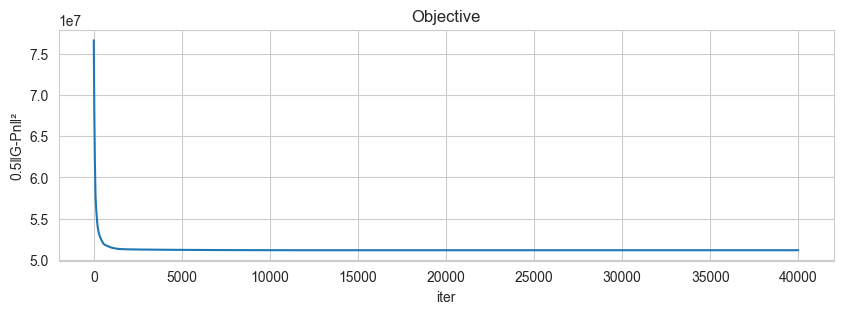

/Users/mt961/Documents/GitHub/ai-workforce-suitability/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


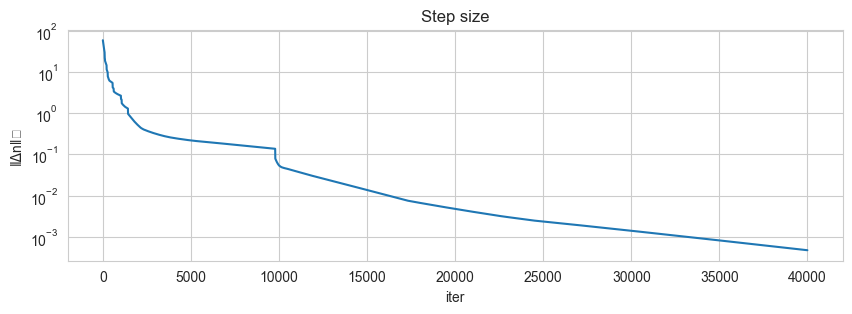

/Users/mt961/Documents/GitHub/ai-workforce-suitability/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


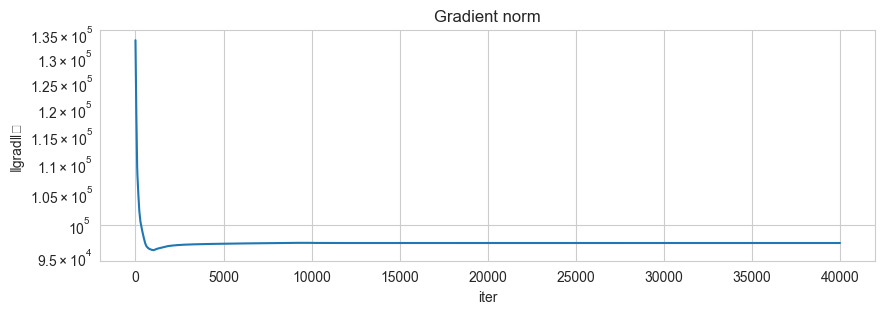

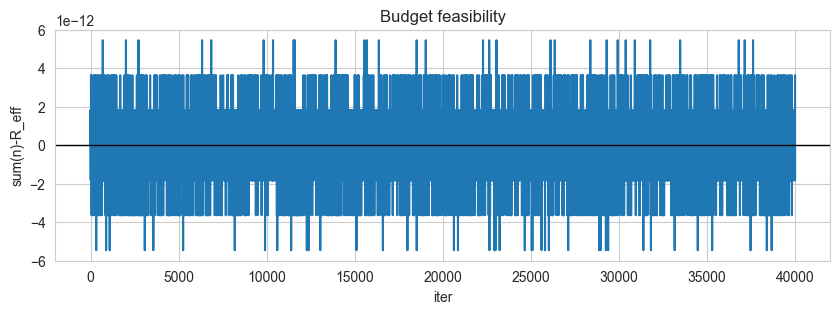

In [979]:
plt.figure(figsize=(10,3))
plt.plot(hist["obj"]); plt.ylabel("0.5‖G-Pn‖²"); plt.xlabel("iter"); plt.title("Objective"); plt.show()

plt.figure(figsize=(10,3))
plt.plot(hist["l1_step"]); plt.ylabel("‖Δn‖₁"); plt.xlabel("iter"); plt.title("Step size"); plt.yscale("log"); plt.show()

plt.figure(figsize=(10,3))
plt.plot(hist["grad_norm"]); plt.ylabel("‖grad‖₂"); plt.xlabel("iter"); plt.title("Gradient norm"); plt.yscale("log"); plt.show()

plt.figure(figsize=(10,3))
plt.plot(hist["sum_resid"]); plt.axhline(0,color='k',lw=1)
plt.ylabel("sum(n)-R_eff"); plt.xlabel("iter"); plt.title("Budget feasibility"); plt.show()

In [980]:
n = alloc_pgd.values.astype(float)  # or your PGD solution vector
caps_vec = cap_items.values.astype(float)

print("sum(n)≈R_eff?", np.isclose(n.sum(), R_eff, rtol=1e-8, atol=1e-6))
print("any <0 or >cap?", (n < -1e-9).any(), (n > caps_vec + 1e-9).any())
print("datasets at cap:", int(np.sum(np.isclose(n, caps_vec, atol=1e-9))), "/", len(n))
print("datasets at 0  :", int(np.sum(np.isclose(n, 0.0, atol=1e-9))), "/", len(n))

sum(n)≈R_eff? True
any <0 or >cap? False False
datasets at cap: 9 / 23
datasets at 0  : 3 / 23


In [981]:
# gradient g = ∇(0.5‖G-Pn‖²) = Pᵀ(Pn - G)
g = P.T @ (P @ n - G_vec)

tol = 1e-10
at_zero = n <= tol
at_cap  = n >= (caps_vec - tol)
free    = (~at_zero) & (~at_cap)

if free.any():
    lam_hat = - g[free].mean()  # estimate λ from free set (g_b + λ = 0)
    stat_free = np.max(np.abs(g[free] + lam_hat))
else:
    lam_hat = 0.0
    stat_free = np.nan

# Complementary-slackness inequality checks
viol_lo = np.max(np.maximum(-(g + lam_hat)[at_zero], 0.0)) if at_zero.any() else 0.0
viol_hi = np.max(np.maximum((g + lam_hat)[at_cap], 0.0))   if at_cap.any()  else 0.0

scale = np.linalg.norm(G_vec) + 1e-12
print(f"KKT stationarity (free): max|g+λ̂| = {stat_free:.3e} (rel {stat_free/scale:.3e})")
print(f"KKT lower-bound viol:    {viol_lo:.3e} (rel {viol_lo/scale:.3e})")
print(f"KKT upper-bound viol:    {viol_hi:.3e} (rel {viol_hi/scale:.3e})")

KKT stationarity (free): max|g+λ̂| = 2.292e+03 (rel 6.524e-02)
KKT lower-bound viol:    1.194e+03 (rel 3.398e-02)
KKT upper-bound viol:    1.580e+03 (rel 4.497e-02)


## Baselines

In [982]:
# --- Helpers (same objective the solver used) ---
def objective(n):
    r = G_vec - P @ n
    return 0.5 * float(r @ r)

def rel_L2(n):
    r = G_vec - P @ n
    return float(np.linalg.norm(r) / (np.linalg.norm(G_vec) + 1e-12))

# --- Guard: need a solved allocation ---
if alloc_pgd is None:
    raise RuntimeError("Optimization did not succeed; no alloc_pgd to compare.")

n_opt = alloc_pgd.values.astype(float)

# --- Baseline 1: uniform over datasets, respecting caps & sum ---
n_uniform = np.minimum(R_eff / B, cap_items.values.astype(float))
n_uniform = project_capped_simplex(n_uniform, cap_items.values, R_eff)  # enforce sum & caps

# --- Baseline 2: cap-proportional (distribute budget by available capacity) ---
cap = cap_items.values.astype(float)
w = cap / max(cap.sum(), 1e-12)
n_capprop = project_capped_simplex(w * R_eff, cap, R_eff)

# --- Baseline 3: random feasible (average a few to gauge variance) ---
rng = np.random.default_rng(0)
rand_trials = []
for _ in range(10):
    weights = rng.random(B)
    weights /= weights.sum()
    n_rand = project_capped_simplex(weights * R_eff, cap, R_eff)
    rand_trials.append(n_rand)
n_rand_mean = np.mean([objective(x) for x in rand_trials])
n_rand_std  = np.std([objective(x) for x in rand_trials])

# --- Report: objective and relative L2 ---
obj_opt  = objective(n_opt)
obj_uni  = objective(n_uniform)
obj_cap  = objective(n_capprop)

rel_opt  = rel_L2(n_opt)
rel_uni  = rel_L2(n_uniform)
rel_cap  = rel_L2(n_capprop)

print(f"Objective(opt)        = {obj_opt:,.2f}")
print(f"Objective(uniform)    = {obj_uni:,.2f}   | improvement = {(1 - obj_opt/obj_uni)*100:,.1f}%")
print(f"Objective(cap-prop)   = {obj_cap:,.2f}   | improvement = {(1 - obj_opt/obj_cap)*100:,.1f}%")
print(f"Objective(random, μ±σ)= {n_rand_mean:,.2f} ± {n_rand_std:,.2f} | improvement vs μ = {(1 - obj_opt/n_rand_mean)*100:,.1f}%")

print()
# how close the allocation comes to the desired assignment profile (0 would mean as close as possible)
print(f"Rel L2(opt)      = {rel_opt:.3f}")
print(f"Rel L2(uniform)  = {rel_uni:.3f}  | improvement = {(rel_uni-rel_opt)/max(rel_uni,1e-12)*100:.1f}%")
print(f"Rel L2(cap-prop) = {rel_cap:.3f}  | improvement = {(rel_cap-rel_opt)/max(rel_cap,1e-12)*100:.1f}%")

Objective(opt)        = 51,162,412.58
Objective(uniform)    = 76,655,348.20   | improvement = 33.3%
Objective(cap-prop)   = 76,891,259.35   | improvement = 33.5%
Objective(random, μ±σ)= 78,854,118.01 ± 6,036,286.52 | improvement vs μ = 35.1%

Rel L2(opt)      = 0.288
Rel L2(uniform)  = 0.352  | improvement = 18.3%
Rel L2(cap-prop) = 0.353  | improvement = 18.4%


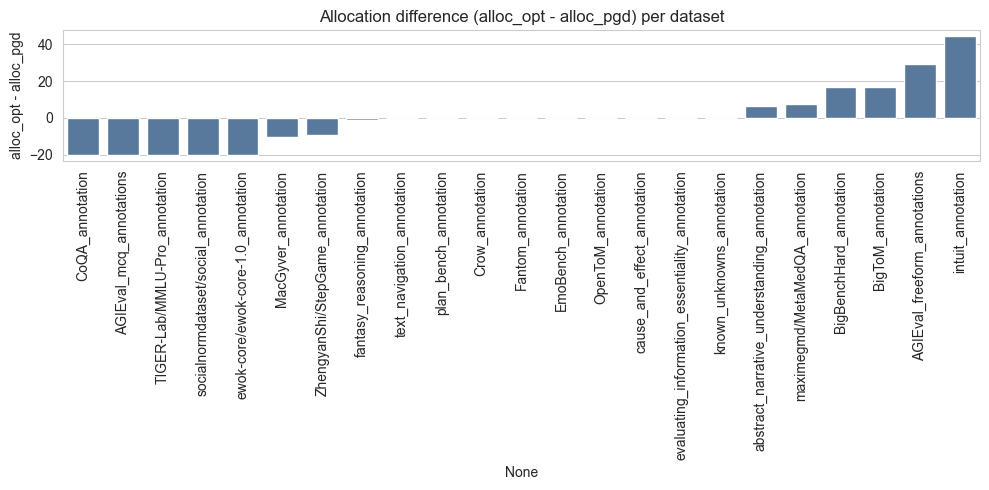

In [983]:
diff = (alloc_opt - alloc_pgd).sort_values()
plt.figure(figsize=(10,5))
sns.barplot(x=diff.index, y=diff.values, color="#4C78A8")
plt.xticks(rotation=90)
plt.ylabel("alloc_opt - alloc_pgd")
plt.title("Allocation difference (alloc_opt - alloc_pgd) per dataset")
plt.tight_layout()
plt.show()

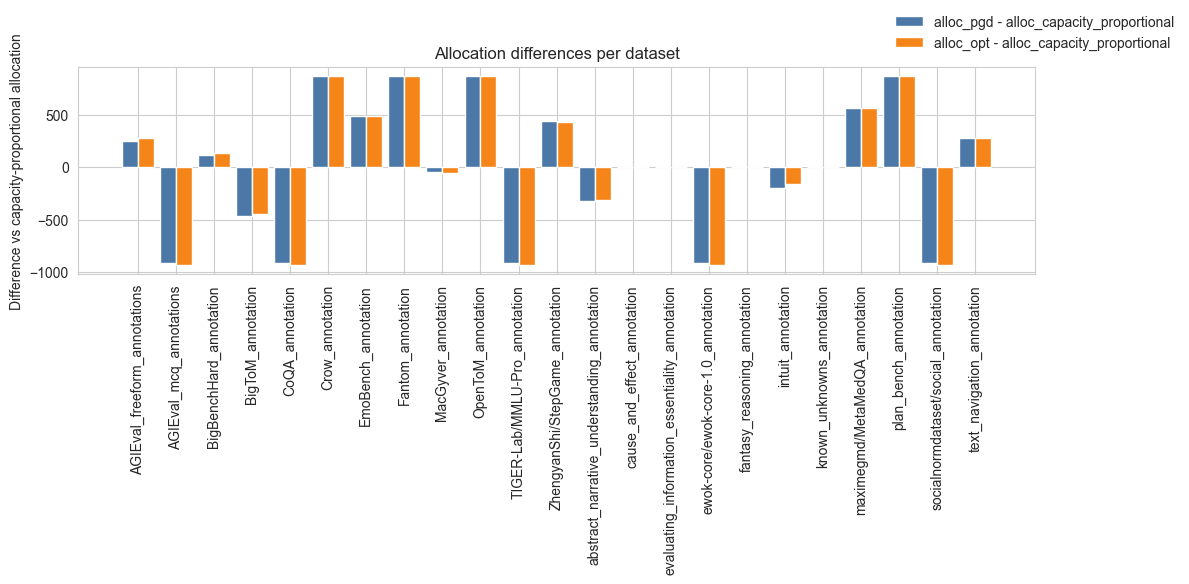

In [984]:
alloc_capacity_proportional = (
    cap_items / cap_items.sum() * R_eff
)

# convert to Series with dataset names as index
alloc_capacity_proportional = pd.Series(alloc_capacity_proportional.values, index=cap_items.index)

# Compare alloc_pgd and alloc_opt against alloc_capacity_proportional
common_idx = alloc_capacity_proportional.index

diff_alloc_pgd = (alloc_pgd.reindex(common_idx).fillna(0) - alloc_capacity_proportional).sort_index()
diff_alloc_opt = (alloc_opt.reindex(common_idx).fillna(0) - alloc_capacity_proportional).sort_index()

plot_df = pd.DataFrame({
    "diff_alloc_pgd": diff_alloc_pgd,
    "diff_alloc_opt": diff_alloc_opt,
})

plt.figure(figsize=(12, 6))
x = np.arange(len(plot_df))
w = 0.42

plt.bar(x - w / 2, plot_df["diff_alloc_pgd"].values, width=w, label="alloc_pgd - alloc_capacity_proportional", color="#4C78A8")
plt.bar(x + w / 2, plot_df["diff_alloc_opt"].values, width=w, label="alloc_opt - alloc_capacity_proportional",
        color="#F58518")

plt.xticks(x, plot_df.index, rotation=90)
plt.ylabel("Difference vs capacity-proportional allocation")
plt.title("Allocation differences per dataset")
plt.legend(loc="lower center", bbox_to_anchor=(1, 1.02), ncol=1, frameon=False)
plt.tight_layout()
plt.show()

In [985]:
residual = G_vec - P @ alloc_pgd.values
rows = [(c, d) for c in capabilities for d in SCORE_BINS]
for i in np.argsort(-np.abs(residual))[:10]:
    c, d = rows[i]
    print((c,d), "resid=", residual[i])

('Emotion Perception and Empathy', 0) resid= -3522.5615856082004
('Prospective Memory', 0) resid= -2905.7633092610195
('Object Permanence', 0) resid= -2626.2927394125745
('Theory of Mind', 0) resid= -2089.9703183129513
('Language', 2) resid= -2086.379721604184
('Planning', 0) resid= -1672.7063125357472
('Semantic Memory', 1) resid= -1559.4751760761555
('Causal Reasoning', 1) resid= -1527.8176355168644
('Inhibitory Control', 1) resid= -1458.1666055712412
('Procedural Memory', 0) resid= -1358.1913629817918


All your top residuals are difficulty d=0 across many capabilities → the datasets you can still sample from produce lots of “easy” assignments, so the optimizer can’t avoid dumping mass there (especially with many datasets already at cap).

In [986]:
rows = [(c, d) for c in capabilities for d in SCORE_BINS]
pos_idx = np.argsort(-(residual))[:10]  # largest positive = underfill
for i in pos_idx:
    c, d = rows[i]
    print((c,d), "underfill =", residual[i])  # positive numbers

('Episodic Memory', 5) underfill = 971.6927211075706
('Causal Reasoning', 4) underfill = 971.6172803043974
('Emotion Perception and Empathy', 4) underfill = 971.6172803043971
('Language', 5) underfill = 970.0975737025237
('Perception and Pattern Recognition', 5) underfill = 970.0975737025237
('Causal Reasoning', 5) underfill = 970.0975737025236
('Object Permanence', 5) underfill = 970.0975737025236
('Mental Simulation', 5) underfill = 970.0975737025236
('Spatial Reasoning and Navigation', 5) underfill = 970.0975737025236
('Inhibitory Control', 5) underfill = 970.0975737025234


# Convert fraction solutions to integers

In [987]:

def round_allocation(alloc, cap_items, R_eff, total_cap):
    """
    Round a continuous allocation to integers while:
      - not exceeding each dataset's capacity
      - preserving the total budget (≈ min(R_eff, total_cap))
      - prioritizing datasets with the largest fractional parts

    Parameters
    ----------
    alloc : pd.Series
        Continuous allocation per dataset
    cap_items : pd.Series
        Capacity per dataset
    R_eff : float
        Effective total budget
    total_cap : float
        Total available capacity

    Returns
    -------
    alloc_int : pd.Series
        Integer allocation per dataset
    """
    # 1) Floor allocations but do not exceed capacity
    alloc_floor = np.minimum(np.floor(alloc).astype(int), cap_items.astype(int))

    # 2) Compute fractional remainders
    remainders = alloc - alloc_floor

    # 3) How many units remain to reach the total budget
    target_total = int(round(min(R_eff, total_cap)))
    to_distribute = target_total - int(alloc_floor.sum())

    # 4) Order datasets by descending fractional remainder
    order = np.argsort(-remainders.values)

    # 5) Distribute leftover units greedily
    alloc_int = alloc_floor.copy()
    i = 0
    while to_distribute > 0 and i < len(order):
        idx = alloc.index[order[i]]
        if alloc_int[idx] < int(cap_items.loc[idx]):  # don’t exceed cap
            alloc_int[idx] += 1
            to_distribute -= 1
        i += 1

    return alloc_int

In [988]:
alloc_opt_int = round_allocation(alloc_opt, cap_items, R_eff, total_cap)
alloc_pgd_int = round_allocation(alloc_pgd, cap_items, R_eff, total_cap)

In [989]:
cap_items

AGIEval_freeform_annotations                       918
AGIEval_mcq_annotations                           1800
BigBenchHard_annotation                           1800
BigToM_annotation                                 1800
CoQA_annotation                                   1800
Crow_annotation                                   1800
EmoBench_annotation                               1000
Fantom_annotation                                 1800
MacGyver_annotation                               1483
OpenToM_annotation                                1800
TIGER-Lab/MMLU-Pro_annotation                     1800
ZhengyanShi/StepGame_annotation                   1800
abstract_narrative_understanding_annotation        800
cause_and_effect_annotation                          0
evaluating_information_essentiality_annotation       0
ewok-core/ewok-core-1.0_annotation                1800
fantasy_reasoning_annotation                         1
intuit_annotation                                 1800
known_unkn

In [1006]:
alloc_opt_int.sum() + items_per_dataset.sum()

np.int64(20000)

In [990]:
alloc_opt_int

AGIEval_freeform_annotations                       748
AGIEval_mcq_annotations                              0
BigBenchHard_annotation                           1065
BigToM_annotation                                  486
CoQA_annotation                                      0
Crow_annotation                                   1800
EmoBench_annotation                               1000
Fantom_annotation                                 1800
MacGyver_annotation                                709
OpenToM_annotation                                1800
TIGER-Lab/MMLU-Pro_annotation                        0
ZhengyanShi/StepGame_annotation                   1363
abstract_narrative_understanding_annotation        103
cause_and_effect_annotation                          0
evaluating_information_essentiality_annotation       0
ewok-core/ewok-core-1.0_annotation                   0
fantasy_reasoning_annotation                         0
intuit_annotation                                  775
known_unkn

In [991]:
alloc_pgd_int

AGIEval_freeform_annotations                       719
AGIEval_mcq_annotations                             20
BigBenchHard_annotation                           1049
BigToM_annotation                                  469
CoQA_annotation                                     20
Crow_annotation                                   1800
EmoBench_annotation                               1000
Fantom_annotation                                 1800
MacGyver_annotation                                720
OpenToM_annotation                                1800
TIGER-Lab/MMLU-Pro_annotation                       20
ZhengyanShi/StepGame_annotation                   1372
abstract_narrative_understanding_annotation         96
cause_and_effect_annotation                          0
evaluating_information_essentiality_annotation       0
ewok-core/ewok-core-1.0_annotation                  20
fantasy_reasoning_annotation                         1
intuit_annotation                                  731
known_unkn

In [992]:
alloc_opt_int / cap_items

AGIEval_freeform_annotations                     0.814815
AGIEval_mcq_annotations                          0.000000
BigBenchHard_annotation                          0.591667
BigToM_annotation                                0.270000
CoQA_annotation                                  0.000000
Crow_annotation                                  1.000000
EmoBench_annotation                              1.000000
Fantom_annotation                                1.000000
MacGyver_annotation                              0.478085
OpenToM_annotation                               1.000000
TIGER-Lab/MMLU-Pro_annotation                    0.000000
ZhengyanShi/StepGame_annotation                  0.757222
abstract_narrative_understanding_annotation      0.128750
cause_and_effect_annotation                           NaN
evaluating_information_essentiality_annotation        NaN
ewok-core/ewok-core-1.0_annotation               0.000000
fantasy_reasoning_annotation                     0.000000
intuit_annotat

# Save allocations as JSON

In [993]:
alloc_dict = {str(k): int(v) for k, v in alloc_opt_int.items()}
with open("item_allocations.json", "w") as f:
    json.dump(alloc_dict, f, indent=2)